In [1]:
# Internal modules
import os
import joblib
from pathlib import Path

# External modules
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# User modules
import src.utils.constantes as cst
import src.utils.summary as summary
import src.utils.auxiliary as auxiliary
from src.processing import dataloader
from src.processing import filtering
import src.models.scorer as scorer
import src.models.models as models
import src.models.display_results as display

%load_ext autoreload
%autoreload 2
# Paths
BASE_DIR = Path("./")
OUTPUT_DIR = BASE_DIR / "results/"
DATA_DIR = BASE_DIR / "data/"

In [2]:
dataset = dataloader.Loader(
    filepath="data/WTconcatenate.csv.gz", sep=","
)

### Dataset options

In [3]:
# Conditions
FILTER_COLUMNS = {
    "Condition": "WT",
    "Type": "CD3",
    "Mask": 1,
    "Density20": True
}
# Filter dataset
REMOVE_NONE = True
REPLACE_ABERRANT = -1

# Sample, feature, target columns
SAMPLE = ["FileName"]
REMOVE_SAMPLE = None
FEATURES = {"fiber-dist-shape": cst.x_fiber_columns}
TARGETS = [dataloader.enrich_2_cmask]
TARGETS_COLNAMES = [target_col(return_key=True) for target_col in TARGETS]

In [4]:
# Replace aberrant values by a default one (places without fiber)
dataset.data.loc[dataset.data["Density20"] <= 0, cst.aberrant_columns] = REPLACE_ABERRANT
dataset.data = dataset.data.assign(**dataloader.enrich_2_cmask(dataset.data))
# Filter out rows & columns
preprocess =filtering.Preprocess(
    rows_categories=FILTER_COLUMNS,
    rows_nonnan=True  # filter row containing nan
)
dataframe = preprocess(dataset.data)

### Model options

In [5]:
# Training regimen
CV = 8  # Number of CV-Folds
LEAVE_ONE_OUT = False  # If True, CV is not used

N_ITER = 50  # RandomSearch settings sampling number
N_PROCESS = max(CV, 1)  # Multi-threading
CV_TRAIN = True
TRAIN = True
SCORING = {
    **scorer.accuracy_score(wrap_scorer=True),
    **scorer.balanced_accuracy_score(wrap_scorer=True),
    **scorer.precision_score(wrap_scorer=True),
    **scorer.recall_score(wrap_scorer=True),
    **scorer.roc_auc_score(wrap_scorer=True),
    **scorer.matthews_corrcoef(wrap_scorer=True),
    **scorer.f1_score(wrap_scorer=True),
}
SCORING_base = {
    **scorer.accuracy_score(wrap_scorer=False),
    **scorer.balanced_accuracy_score(wrap_scorer=False),
    **scorer.precision_score(wrap_scorer=False),
    **scorer.recall_score(wrap_scorer=False),
    **scorer.roc_auc_score(wrap_scorer=False),
    **scorer.matthews_corrcoef(wrap_scorer=False),
    **scorer.f1_score(wrap_scorer=False),
}
FIT_WITH = "f1"
TARGETS_WEIGHTS = "balanced"
## Hyperparameters search
hsearch_criterion = ["entropy",]
hsearch_n_estimators = [16, 32, 64, 80]
hsearch_max_features = ["sqrt"]
hsearch_max_depths = [10, 15, 20]
hsearch_min_s_split = [2, 4, 8]
hsearch_min_s_leaf = [1, 5]
hsearch_bootstrap = [True]
hsearch_class_weight = ["balanced"]

# Generic attributes
SEED = 42
TEST_SIZE = 0.3

# Importances attributes
N_PERM = 30
N_BORUTA = None

## Process
SAMPLE_GROUP = None if SAMPLE == [] else SAMPLE
CV = 1 if LEAVE_ONE_OUT else CV
TRAIN_NEW_MODEL = True

In [6]:
filename = []
for key, val in FILTER_COLUMNS.items():
    if isinstance(val, list):
        val = [str(v) for v in val]
        val = str(key) + "=" + "-".join(val)
    elif isinstance(val, (int, bool)):
        val = str(key) + "=" + str(val)
    filename.append(val)
filename = "_".join(filename)
filename

'WT_CD3_Mask=1_Density20=True'

In [ ]:
rootname = filename
rootname = "LEAVE-ONE-OUT_" + rootname if LEAVE_ONE_OUT else rootname
rootname = "UNGROUP_" + rootname if SAMPLE_GROUP is None else rootname 
# Summary either for new model, or an already existant one
summary_name = "summary.txt" if TRAIN_NEW_MODEL else "summary_estimator.txt"
param_name = "search_param.csv" if TRAIN_NEW_MODEL else "estimator_param.csv"
param_reduced_name = "search_param-reduced_val.csv" if TRAIN_NEW_MODEL else "estimator_param_val.csv"
model_name = "best_estimator.joblib" if TRAIN_NEW_MODEL else "estimator.joblib"
# Define X and Y
for target_column in TARGETS_COLNAMES:
    for key, features_column in FEATURES.items():
        # Saving output
        loader_name = f"{rootname}_{key}_{target_column}"  # MAIN DIR
        auxiliary.create_dir(OUTPUT_DIR)
        loader_dir = auxiliary.create_dir(os.path.join(OUTPUT_DIR, loader_name), add_suffix=False)
        # dir
        cv_dir = auxiliary.create_dir(os.path.join(loader_dir, "cv"), add_suffix=False)
        cv_plot_dir = auxiliary.create_dir(os.path.join(cv_dir, "plots"), add_suffix=False)
        model_dir = auxiliary.create_dir(os.path.join(loader_dir, "main"), add_suffix=False)
        train_test_dir = auxiliary.create_dir(os.path.join(loader_dir, "train_test"), add_suffix=False)
        train_test_plot_dir = auxiliary.create_dir(os.path.join(train_test_dir, "plots"), add_suffix=False)
        train_test_n_dir = auxiliary.create_dir(os.path.join(loader_dir, "n_models"), add_suffix=False)
        train_test_n_plot_dir = auxiliary.create_dir(os.path.join(train_test_n_dir, "plots"), add_suffix=False)
        train_test_n_i_dir = os.path.join(train_test_n_dir, "model_{i}")  # use with str.format
        train_test_n_i_plot_dir = os.path.join(train_test_n_i_dir, "plots")  # use with str.format
        # files
        summary_file = os.path.join(loader_dir, summary_name)
        hsearch_file = os.path.join(loader_dir, "search_param.csv")
        hsearch_after_file = os.path.join(loader_dir, param_name)
        hsearch_train_file = os.path.join(cv_dir, "search_param-reduced_train.csv")
        hsearch_val_file = os.path.join(cv_dir, param_reduced_name)
        model_file = os.path.join(model_dir, model_name)

        cv_scores_train_file = os.path.join(cv_dir, "cv_scores_train.csv")
        cv_scores_test_file = os.path.join(cv_dir, "cv_scores_test.csv")
        cv_scores_train_plot_file = os.path.join(cv_plot_dir, "cv_scores_train.png")
        cv_scores_val_plot_file = os.path.join(cv_plot_dir, "cv_scores_val.png")
        cv_cfmatrix_train_file = os.path.join(cv_plot_dir, "cv_cfmatrix_train.png")
        cv_cfmatrix_val_file = os.path.join(cv_plot_dir, "cv_cfmatrix_val.png")
        
        scores_train_file = os.path.join(train_test_dir, "scores_train.csv")
        scores_test_file = os.path.join(train_test_dir, "scores_test.csv")
        train_test_score_plot_file = os.path.join(train_test_plot_dir, "train-test_score.png")
        cfmatrix_plot_train_file = os.path.join(train_test_plot_dir, "cfmatrix_train.png")
        cfmatrix_plot_test_file = os.path.join(train_test_plot_dir, "cfmatrix_test.png")
        
        mdi_importance_file = os.path.join(train_test_dir, "mean-decrease-impurity.csv")
        raw_permut_importance_train_file = os.path.join(train_test_dir, "raw_permutation_train.csv")
        raw_permut_importance_test_file = os.path.join(train_test_dir, "raw_permutation_test.csv")
        permut_importance_train_file = os.path.join(train_test_dir, "permutation_train.csv")
        permut_importance_test_file = os.path.join(train_test_dir, "permutation_test.csv")
        boruta_importance_train_file = os.path.join(train_test_dir, "boruta_train.csv")
        boruta_importance_test_file = os.path.join(train_test_dir, "boruta_test.csv")
        mdi_plot_file = os.path.join(train_test_plot_dir, "mean-decrease-impurity.png")
        permut_plot_train_file = os.path.join(train_test_plot_dir, "permutation_train.png")
        permut_plot_train_boxplot_file = os.path.join(train_test_plot_dir, "permutation_boxplot_train.png")
        permut_plot_train_violin_file = os.path.join(train_test_plot_dir, "permutation_violin_train.png")
        permut_plot_test_file = os.path.join(train_test_plot_dir, "permutation_test.png")
        permut_plot_test_boxplot_file = os.path.join(train_test_plot_dir, "permutation_boxplot_test.png")
        permut_plot_test_violin_file = os.path.join(train_test_plot_dir, "permutation_violin_test.png")
        boruta_plot_train_file = os.path.join(train_test_plot_dir, "boruta_train.png")
        boruta_plot_test_file = os.path.join(train_test_plot_dir, "boruta_test.png")
        shap_plot_train_file = os.path.join(train_test_plot_dir, "shap_train.png")
        shap_plot_test_file = os.path.join(train_test_plot_dir, "shap_test.png")
        # For the N models (with N=Number of folds)
        model_i_file = os.path.join(model_dir, "estimator_{i}.joblib")
        n_scores_test_file = os.path.join(train_test_n_dir, "n_scores_test.csv")
        mdi_i_importance_file = "model_{i}_mean-decrease-impurity.csv"  # to join
        mdi_i_plot_file = "model_{i}_mean-decrease-impurity.png"
        raw_i_permut_importance_train_file = "model_{i}_raw_permutation_train.csv"
        raw_i_permut_importance_test_file = "model_{i}_raw_permutation_test.csv"
        permut_i_importance_train_file = "model_{i}_permutation_train.csv"
        permut_i_importance_test_file = "model_{i}_permutation_test.csv"
        permut_i_plot_train_file = "model_{i}_permutation_train.png"
        permut_i_plot_test_file = "model_{i}_permutation_test.png"
        n_confusion_test_file = os.path.join(train_test_n_dir, "n_confusion_test.csv")
        n_confusion_train_file = os.path.join(train_test_n_dir, "n_confusion_train.csv")
        n_mdi_file = os.path.join(train_test_n_dir, "n_mdi.csv")
        n_permut_train_file = os.path.join(train_test_n_dir, "n_permutation_train.csv")
        n_permut_test_file = os.path.join(train_test_n_dir, "n_permutation_test.csv")
        mean_cfmatrix_plot_train_file = os.path.join(train_test_n_plot_dir, "cfmatrix_train.png")
        mean_cfmatrix_plot_test_file = os.path.join(train_test_n_plot_dir, "cfmatrix_test.png")

        summary.summarize(
            summary.mapped_summary({
                "Condition": FILTER_COLUMNS["Condition"],
                "Type": FILTER_COLUMNS["Type"],
                "Tumor": FILTER_COLUMNS["Mask"],
                "Fiber": FILTER_COLUMNS["Density20"],
                "Remove none": REMOVE_NONE,
                "Replace aberrant": REPLACE_ABERRANT,
                "NJOBS (Multi-threading)": N_PROCESS,
                "SEED": SEED,
            }, map_sep=":"),
            summary.arg_summary(
                "Importance parameters",
                "\n" +
                summary.mapped_summary({
                    "N-Permutation shuffle": N_PERM,
                    "N-Boruta trials": N_BORUTA,
                }, map_sep="=", padding_left=4),
                new_line=False
            ),
            title="Parameters",
            filepath=summary_file, mode="w"
        )

        summary.summarize(
            summary.mapped_summary({
                "MODEL": models.ESTIMATOR,
                "TEST RATIO": TEST_SIZE,
                "GROUPS": True if SAMPLE_GROUP else False,
                "Cross-validation N-Folds": "Leave one out" if LEAVE_ONE_OUT else CV,
                "RandomSearch N-iter": N_ITER,
                "Select best model with": FIT_WITH
            }, map_sep=":"),
            summary.arg_summary(
                "Scoring",
                "\n" + summary.mapped_summary(SCORING, padding_left=4),
                new_line=False
            ),
            subtitle="Training regiment",
            filepath=summary_file
        )
        # Save search parameters for new model
        if TRAIN_NEW_MODEL:
            summary.arg_summary(
                "Hyperparameters search",
                "\n" +
                summary.mapped_summary({
                    "Criterion": hsearch_criterion,
                    "N-Tree": hsearch_n_estimators,
                    "N-Features": hsearch_max_features,
                    "Max depths": hsearch_max_depths,
                    "Min sample split": hsearch_min_s_split,
                    "Min sample leaf": hsearch_min_s_leaf,
                    "Bootstrap": hsearch_bootstrap,
                    "Class-weight": hsearch_class_weight
                }, map_sep="=", padding_left=4),
                new_line=False, filepath=summary_file
            )

        # Features and Target(s)
        x, y, groups = models.split_xy(
            df=dataframe, x_columns=features_column, y_columns=target_column, groups=SAMPLE_GROUP
        )
        mapped_groups = None
        if SAMPLE_GROUP:
            label_groups = pd.DataFrame(dataframe[SAMPLE_GROUP].agg(';'.join, axis=1), columns=["label"])
            df_mapped_groups = label_groups.assign(groups=groups).drop_duplicates()    
            mapped_groups = dict(zip(df_mapped_groups.label, df_mapped_groups.groups))

        summary.df_summary(
            x=x, y=y,
            unique_groups=np.unique(groups),
            x_columns=features_column,
            y_columns=target_column,
            groups_columns=SAMPLE_GROUP,
            mapped_groups=mapped_groups,
            new_line=True,
            filepath=summary_file
        )

        # Train, Val, Test
        x_train, x_test, y_train, y_test, groups_train, groups_test = models.split_data(
            x, y, groups=groups, n_splits=1, test_size=TEST_SIZE, stratify=True, seed=SEED
        )
        u_groups_train = np.unique(groups_train) if groups_train is not None else None
        u_groups_test = np.unique(groups_test) if groups_test is not None else None
        if not LEAVE_ONE_OUT:
            summary.summarize(
                summary.xy_summary(
                    x_train, y_train, unique_groups=u_groups_train, title="Train",
                    x_label="x_train shape", y_label="y_train shape", groups_label="groups_train",
                ),
                summary.xy_summary(
                    x_test, y_test, unique_groups=u_groups_test, title="Test",
                    x_label="x_test shape", y_label="y_test shape", groups_label="groups_test",
                ),
                filepath=summary_file
            )

        # Kfold generator
        cv_generator = models.cv_object(
            n_split=CV, groups=groups_train, stratify=True, seed=SEED
        )
        # Model
        estimator = None  # model trained on train
        estimator_list = []  # models trained on train cv
        estimator_param = dict()  # model parameters
        # Score of model on each cv split
        df_scores = None
        idx_scores = None  # best model row index
        # Hyperparameters search
        if TRAIN_NEW_MODEL:
            search = None
            if not LEAVE_ONE_OUT:
                # Default cross-validation
                search = models.random_forest_search(
                    x=x_train, y=y_train.ravel(), groups=groups_train,
                    n_split=CV, stratify=True, seed=SEED, verbose=1,
                    scoring=SCORING, n_iter=N_ITER, refit=FIT_WITH, n_jobs=N_PROCESS,
                    class_weight=TARGETS_WEIGHTS, return_train_score=CV_TRAIN,
                    cv_generator=cv_generator, random_state=SEED,
                    param_criterion=hsearch_criterion,
                    param_n_estimators=hsearch_n_estimators,
                    param_max_features=hsearch_max_features,
                    param_max_depths=hsearch_max_depths,
                    param_min_s_split=hsearch_min_s_split,
                    param_min_s_leaf=hsearch_min_s_leaf,
                    param_bootstrap=hsearch_bootstrap,
                    param_class_weight=hsearch_class_weight,
                )
            else:
                # Leave one out (use all dataset)
                search = models.random_forest_search(
                    x=x, y=y.ravel(), groups=groups,
                    n_split=CV, stratify=True, seed=SEED, verbose=1,
                    scoring=SCORING, n_iter=N_ITER, refit=FIT_WITH, n_jobs=N_PROCESS,
                    class_weight=TARGETS_WEIGHTS, return_train_score=CV_TRAIN,
                    cv_generator=cv_generator, random_state=SEED,
                    param_criterion=hsearch_criterion,
                    param_n_estimators=hsearch_n_estimators,
                    param_max_features=hsearch_max_features,
                    param_max_depths=hsearch_max_depths,
                    param_min_s_split=hsearch_min_s_split,
                    param_min_s_leaf=hsearch_min_s_leaf,
                    param_bootstrap=hsearch_bootstrap,
                    param_class_weight=hsearch_class_weight,
                )
            # Model from searched parameters
            estimator = search.best_estimator_
            estimator_param = search.best_params_
            # Save tested parameters
            idx_scores = search.best_index_
            df_search = pd.DataFrame(search.cv_results_)
            df_search.to_csv(hsearch_file)
            df_scores = df_search.iloc[idx_scores]
        # Search for existing file parameters
        else:
            search_results = None
            if auxiliary.isfile(hsearch_file):
                search_results = pd.read_csv(hsearch_file)
                search_param = search_results.loc[search_results[f"rank_test_{FIT_WITH}"] == 1]["params"]
                estimator_param = eval(search_param.values[0])
            elif isinstance(TRAIN_NEW_MODEL, str): # Search for other file ? or apply randomsearch ?
                if auxiliary.isfile(TRAIN_NEW_MODEL):
                    search_results = pd.read_csv(TRAIN_NEW_MODEL)
            else:
                raise Exception("Param File not found, change TRAIN_NEW_MODEL to False")

            # Model from already searched parameters
            estimator = RandomForestClassifier(**estimator_param, random_state=SEED)
            estimator.fit(x_train, y_train.ravel())
            idx_scores = 0

        # Save model
        joblib.dump(estimator, model_file)
        # List of model trained on each Train CV
        dict_scores = dict()
        for i, (train_index, val_index) in enumerate(cv_generator.split(x_train, y_train, groups_train)):
            model_i = RandomForestClassifier(**estimator_param, random_state=SEED)
            model_i.fit(x[train_index, :], y[train_index].ravel())
            estimator_list.append(model_i)
            # Save model {i}
            joblib.dump(model_i, model_i_file.format(i=i))
            if not TRAIN_NEW_MODEL:
                dict_scores_i = models.scorer_model(
                    model_i, x[val_index, :], y[val_index], SCORING_base,
                    prefix=f"split{i}_test_"
                )
                dict_scores = {**dict_scores, **dict_scores_i}
                if CV_TRAIN:
                    dict_scores_i_train = models.scorer_model(
                        model_i, x[train_index, :], y[train_index], SCORING_base,
                        prefix=f"split{i}_train_"
                    )
                    dict_scores = {**dict_scores, **dict_scores_i_train}
        
        # N-Folds to summary
        N_scores = -1
        if SAMPLE_GROUP:
            if LEAVE_ONE_OUT:
                N_scores = len(mapped_groups)
            else:
                N_scores = CV
        else:
            if LEAVE_ONE_OUT:
                N_scores = len(x)
            else:
                N_scores = CV

        # Scores is None if search was not used
        if df_scores is None:
            df_scores = pd.DataFrame(dict_scores)
            # Compute mean for each metric
            for key in SCORING.keys():
                split_scores_str = [f"split{i}_test_{key}" for i in range(N_scores)]
                df_scores.loc[:, [f"mean_test_{key}"]] = df_scores[split_scores_str].mean(numeric_only=True, axis=1)
                df_scores.loc[:, [f"std_test_{key}"]] = df_scores[split_scores_str].std(numeric_only=True, axis=1)
                if CV_TRAIN:
                    split_scores_train_str = [f"split{i}_train_{key}" for i in range(N_scores)]
                    df_scores.loc[:, [f"mean_train_{key}"]] = df_scores[split_scores_train_str].mean(numeric_only=True, axis=1)
                    df_scores.loc[:, [f"std_train_{key}"]] = df_scores[split_scores_train_str].std(numeric_only=True, axis=1)
                df_scores.loc[:, [f"rank_test_{key}"]] = 1

            # Save performances
            df_scores.to_csv(hsearch_after_file)

        summary.summarize(title="Results", filepath=summary_file)
        for i in range(N_scores):
            split_scores_str = [f"split{i}_test_{key}" for key in SCORING.keys()]
            result_i_scores = dict(zip(split_scores_str, df_scores[split_scores_str].values.ravel()))
            summary.arg_summary(
                f"Split {i}",
                "\n" +
                summary.mapped_summary(
                    result_i_scores,
                    map_sep="=", padding_left=4
                ),
                new_line=True,
                filepath=summary_file
            )

        ## In clearer format
        cv_val_scores = {"model": [], "mean": [], "std": [], "rank": [], "score": []}
        cv_train_scores = {"model": [], "mean": [], "std": [], "score": []}
        for idx, key in enumerate(SCORING.keys()):
            key_score = [key] * N_ITER
            key_model = [i for i in range(N_ITER)]
            cv_val_scores["model"].extend(key_model)
            cv_val_scores["mean"].extend(df_scores[f"mean_test_{key}"].ravel().tolist())
            cv_val_scores["std"].extend(df_scores[f"std_test_{key}"].ravel().tolist())
            cv_val_scores["score"].extend(key_score)
            cv_val_scores["rank"].extend(df_scores[f"rank_test_{key}"].ravel().tolist())
            if CV_TRAIN:
                cv_train_scores["model"].extend(key_model)
                cv_train_scores["mean"].extend(df_scores[f"mean_train_{key}"].ravel().tolist())
                cv_train_scores["std"].extend(df_scores[f"std_train_{key}"].ravel().tolist())
                cv_train_scores["score"].extend(key_score)

        df_cv_train_scores = None
        df_cv_val_scores = pd.DataFrame(cv_val_scores)
        df_cv_val_scores.to_csv(hsearch_val_file, index=False)
        display.display_cv_scores(df_cv_val_scores, filepath=cv_scores_val_plot_file, title="CV performances")
        if CV_TRAIN:
            df_cv_train_scores = pd.DataFrame(cv_train_scores)
            df_cv_train_scores.to_csv(hsearch_train_file, index=False)
            display.display_cv_scores(df_cv_train_scores, filepath=cv_scores_train_plot_file, title="CV performances")

        # CV - Confusion matrix
        observed_cv_val, predicted_cv_val = models.predict_kmodel(
            x=x_train, y=y_train, estimator=estimator,
            kfolder=cv_generator.split(x_train, y_train.ravel(), groups_train),
            return_train=False
        )
        display.display_confusion_matrix(
            observed=observed_cv_val, predicted=predicted_cv_val,
            labels=None, filepath=cv_cfmatrix_val_file
        )
        cv_perf_val, cv_perf_str_val = dict(), dict()
        cv_perf_train, cv_perf_str_train = (dict(), dict()) if CV_TRAIN else (None, None)
        for idx, key in enumerate(SCORING.keys()):  # TODO: Save a raw output of mean, std of best model in Train/Val
            key_mean_val = df_scores[f'mean_test_{key}'].iloc[idx_scores]
            key_std_val = df_scores[f'std_test_{key}'].iloc[idx_scores]
            cv_perf_val["mean"] = cv_perf_val.get("mean", []) + [key_mean_val]
            cv_perf_val["std"] = cv_perf_val.get("std", []) + [key_std_val]
            cv_perf_val["score"] = cv_perf_val.get("score", []) + [key]
            cv_perf_str_val[key] = \
                f"mean={key_mean_val:.3f} "u'\u00b1'f" {key_std_val:.3f}"
            if CV_TRAIN:
                key_mean_train = df_scores[f'mean_train_{key}'].iloc[idx_scores]
                key_std_train = df_scores[f'std_train_{key}'].iloc[idx_scores]
                cv_perf_train["mean"] = cv_perf_train.get("mean", []) + [key_mean_train]
                cv_perf_train["std"] = cv_perf_train.get("std", []) + [key_std_train]
                cv_perf_train["score"] = cv_perf_train.get("score", []) + [key]
                cv_perf_str_train[key] = \
                    f"mean={key_mean_train:.3f} "u'\u00b1'f" {key_std_train:.3f}"

        # Save raw cv scores
        pd.DataFrame(cv_perf_val).to_csv(cv_scores_test_file, index=False)
        if CV_TRAIN:
            pd.DataFrame(cv_perf_train).to_csv(cv_scores_train_file, index=False)

        parameters_str = "Best parameters" if TRAIN_NEW_MODEL else "Parameters"
        summary.summarize(
            summary.arg_summary(
                parameters_str,
                "\n" +
                summary.mapped_summary(
                    estimator_param,
                    map_sep="=", padding_left=4
                ),
                new_line=False
            ),
            summary.arg_summary(
                "CV Val", "\n" + summary.mapped_summary(cv_perf_str_val, map_sep="=", padding_left=4),
                new_line=False
            ),
            filepath=summary_file
        )
        if CV_TRAIN:
            summary.arg_summary(
                "CV Train", "\n" + summary.mapped_summary(cv_perf_str_train, map_sep="=", padding_left=4),
                filepath=summary_file
            )

        if not LEAVE_ONE_OUT:
            # Train, Test - Score
            ## Train
            train_scores = models.scorer_model(
                estimator=estimator,
                x=x_train, y=y_train, scorer=SCORING_base
            )

            summary.arg_summary(
                "Train", "\n" + summary.mapped_summary(
                    train_scores, map_sep="=", padding_left=4
                ), filepath=summary_file
            )

            df_train_scores = pd.DataFrame(train_scores).T
            df_train_scores.to_csv(scores_train_file)
            ## Test
            test_scores = models.scorer_model(
                estimator=estimator,
                x=x_test, y=y_test, scorer=SCORING_base
            )
            summary.arg_summary(
                "Test", "\n" + summary.mapped_summary(
                    test_scores, map_sep="=", padding_left=4
                ), filepath=summary_file
            )
            df_test_scores = pd.DataFrame(test_scores).T
            df_test_scores.to_csv(scores_test_file)

            # N models - Calculate score on test
            n_test_scores_dict = dict()
            for i, model_i in enumerate(estimator_list):
                scores_test_i = models.scorer_model(
                    estimator=model_i,
                    x=x_test, y=y_test, scorer=SCORING_base,
                    prefix=f"model_{i}"
                )
                n_test_scores_dict = {**n_test_scores_dict, **scores_test_i}
            # Save to csv
            pd.DataFrame(n_test_scores_dict).to_csv(n_scores_test_file)

            # Train, Test - Score
            display.display_train_test_scores(
                train_scores=train_scores,
                test_scores=test_scores,
                title="Score", filepath=train_test_score_plot_file
            )
            # Train, Test - Confusion matrix
            if TRAIN:
                observed_train, predicted_train = models.predict_model(x_train, y_train, estimator)
                display.display_confusion_matrix(
                    observed=observed_train, predicted=predicted_train, cmap="Reds",
                    labels=None, filepath=cfmatrix_plot_train_file, title=f"train: {target_column}"
                )
            observed_test, predicted_test = models.predict_model(x_test, y_test, estimator)
            display.display_confusion_matrix(
                observed=observed_test, predicted=predicted_test, cmap="Greens",
                labels=None, filepath=cfmatrix_plot_test_file, title=f"test: {target_column}"
            )

        # Feature Importance
        ## Mean Decrease Impurity
        df_mdi = pd.DataFrame(
            models.forest_mdi_importance(rf_estimator=estimator, colnames=features_column)
        )
        df_mdi.to_csv(mdi_importance_file, index=False)
        display.display_mdi_importance(mdi_importance=df_mdi, filepath=mdi_plot_file)

        ## Permutation
        ### Train
        permutation_train = models.forest_permutation_importance(
            estimator=estimator, x=x_train, y=y_train.ravel(),
            scoring=SCORING[FIT_WITH], n_repeats=N_PERM,
            colnames=features_column, n_jobs=N_PROCESS, seed=SEED
        )
        raw_permutation_train = pd.DataFrame(permutation_train.importances.T, columns=features_column)
        df_permutation_train = pd.DataFrame({
            "importances_mean": permutation_train["importances_mean"],
            "importances_std": permutation_train["importances_std"],
            "colnames": permutation_train["colnames"]
        })
        raw_permutation_train.to_csv(raw_permut_importance_train_file, index=False)
        df_permutation_train.to_csv(permut_importance_train_file, index=False)
        display.display_permutation_importance(df_permutation_train, filepath=permut_plot_train_file)
        display.display_raw_importance(raw_permutation_train, filepath=permut_plot_train_boxplot_file)
        display.display_raw_importance(raw_permutation_train, violin=True, filepath=permut_plot_train_violin_file)
        ### Test
        permutation_test = models.forest_permutation_importance(
            estimator=estimator, x=x_test, y=y_test.ravel(),
            scoring=SCORING[FIT_WITH], n_repeats=N_PERM,
            colnames=features_column,  n_jobs=N_PROCESS, seed=SEED
        )
        raw_permutation_test = pd.DataFrame(permutation_test.importances.T, columns=features_column)
        df_permutation_test = pd.DataFrame({
            "importances_mean": permutation_test["importances_mean"],
            "importances_std": permutation_test["importances_std"],
            "colnames": permutation_test["colnames"]
        })
        raw_permutation_test.to_csv(raw_permut_importance_test_file, index=False)
        df_permutation_test.to_csv(permut_importance_test_file, index=False)
        display.display_permutation_importance(df_permutation_test, filepath=permut_plot_test_file)
        display.display_raw_importance(raw_permutation_test, filepath=permut_plot_test_boxplot_file)
        display.display_raw_importance(raw_permutation_test, violin=True, filepath=permut_plot_test_violin_file)

        # Apply it with list of model
        ## Confusion matrix
        obs_pred_test_list = list()
        confusion_test_dict = dict()
        obs_pred_train_list = list()
        confusion_train_dict = dict()
        for i, model_i in enumerate(estimator_list):
            observed_test, predicted_i_test = models.predict_model(x_test, y_test, model_i)
            confusion_test_i = models.get_tn_fp_fn_tp(
                observed_test, predicted_i_test,
                prefix=f"model_{i}"
            )
            obs_pred_test_list.append([observed_test, predicted_i_test])
            confusion_test_dict = {**confusion_test_dict, **confusion_test_i}
            if TRAIN:
                observed_train, predicted_i_train = models.predict_model(x_train, y_train, model_i)
                confusion_train_i = models.get_tn_fp_fn_tp(
                    observed_train, predicted_i_train,
                    prefix=f"model_{i}"
                )
                obs_pred_train_list.append([observed_train, predicted_i_train])
                confusion_train_dict = {**confusion_train_dict, **confusion_train_i}
        # Save tn, fp, fn, tp
        pd.DataFrame(confusion_test_dict).to_csv(n_confusion_test_file, index=False)
        display.display_mean_confusion_matrix(
            obs_pred_test_list, cmap="Greens", labels=None,
            filepath=mean_cfmatrix_plot_test_file, title=f"mean test performance"
        )
        if TRAIN:
            pd.DataFrame(confusion_train_dict).to_csv(n_confusion_train_file, index=False)
            display.display_mean_confusion_matrix(
                obs_pred_train_list, cmap="Reds", labels=None,
                filepath=mean_cfmatrix_plot_train_file, title=f"mean train performance"
            )

        # Mean decrease accuracy
        n_mdi = dict()
        for i, model_i in enumerate(estimator_list):
            model_i_dir = auxiliary.create_dir(train_test_n_i_dir.format(i=i), add_suffix=False)  # dir
            model_i_plot_dir = auxiliary.create_dir(train_test_n_i_plot_dir.format(i=i), add_suffix=False)  # subdir
            mdi_i = models.forest_mdi_importance(rf_estimator=model_i, colnames=features_column)
            n_mdi = {  # save all results in one dict
                **n_mdi,
                f"model_{i}_importances_mean": mdi_i['importances_mean'],
                f"model_{i}_importances_std": mdi_i["importances_std"],
            }
            # Save output for model {i}
            df_mdi_i = pd.DataFrame(mdi_i)
            df_mdi_i.to_csv(os.path.join(model_i_dir, mdi_i_importance_file.format(i=i)), index=False)
            display.display_mdi_importance(mdi_importance=df_mdi_i, filepath=os.path.join(model_i_plot_dir, mdi_i_plot_file.format(i=i)))
        # Assign column names
        n_mdi["colnames"] = features_column
        # Save concatenated mdi
        pd.DataFrame(n_mdi).to_csv(n_mdi_file, index=False)

        # Permutation
        n_permut_test = dict()
        n_permut_train = dict()
        for i, model_i in enumerate(estimator_list):
            model_i_dir = auxiliary.create_dir(train_test_n_i_dir.format(i=i), add_suffix=False)  # dir
            model_i_plot_dir = auxiliary.create_dir(train_test_n_i_plot_dir.format(i=i), add_suffix=False)  # subdir
            ## Train
            permutation_train_i = models.forest_permutation_importance(
                estimator=model_i, x=x_train, y=y_train.ravel(),
                scoring=SCORING[FIT_WITH], n_repeats=N_PERM,
                colnames=features_column,  n_jobs=N_PROCESS, seed=SEED
            )
            n_permut_train = {
                **n_permut_train,
                f"model_{i}_importances_mean": permutation_train_i["importances_mean"],
                f"model_{i}_importances_std": permutation_train_i["importances_std"],
            }
            # Save output for model {i}
            raw_permutation_i_train = pd.DataFrame(permutation_train_i.importances.T, columns=features_column)
            df_permutation_i_train = pd.DataFrame({
                "importances_mean": permutation_train_i["importances_mean"],
                "importances_std": permutation_train_i["importances_std"],
                "colnames": permutation_train_i["colnames"]
            })
            df_permutation_i_train.to_csv(
                os.path.join(model_i_dir, permut_i_importance_train_file.format(i=i)),
                index=False
            )
            raw_permutation_i_train.to_csv(
                os.path.join(model_i_dir, raw_i_permut_importance_train_file.format(i=i)),
                index=False
            )
            display.display_permutation_importance(
                df_permutation_i_train,
                filepath=os.path.join(model_i_plot_dir, permut_i_plot_train_file.format(i=i)),
            )
            ## Test
            permutation_test_i = models.forest_permutation_importance(
                estimator=model_i, x=x_test, y=y_test.ravel(),
                scoring=SCORING[FIT_WITH], n_repeats=N_PERM,
                colnames=features_column,  n_jobs=N_PROCESS, seed=SEED
            )
            n_permut_test = {
                **n_permut_test,
                f"model_{i}_importances_mean": permutation_test_i["importances_mean"],
                f"model_{i}_importances_std": permutation_test_i["importances_std"],
            }
            # Save output for model {i}
            raw_permutation_i_test = pd.DataFrame(permutation_test_i.importances.T, columns=features_column)
            df_permutation_i_test = pd.DataFrame({
                "importances_mean": permutation_test_i["importances_mean"],
                "importances_std": permutation_test_i["importances_std"],
                "colnames": permutation_test_i["colnames"]
            })
            df_permutation_i_test.to_csv(
                os.path.join(model_i_dir, permut_i_importance_test_file.format(i=i)),
                index=False
            )
            raw_permutation_i_test.to_csv(
                os.path.join(model_i_dir, raw_i_permut_importance_test_file.format(i=i)),
                index=False
            )
            display.display_permutation_importance(
                df_permutation_i_test,
                filepath=os.path.join(model_i_plot_dir, permut_i_plot_test_file.format(i=i))
            )
        # Assign column names
        n_permut_train["colnames"] = features_column
        n_permut_test["colnames"] = features_column
        # Save to csv
        pd.DataFrame(n_permut_train).to_csv(n_permut_train_file, index=False)
        pd.DataFrame(n_permut_test).to_csv(n_permut_test_file, index=False)

        ## Boruta
        if N_BORUTA is not None:
            ### Train
            boruta_train = models.forest_boruta_importance(
                estimator=estimator, x=x_train, y=y_train.ravel(),
                colnames=features_column, n_trials=N_BORUTA
            )
            df_boruta_train = pd.DataFrame(boruta_train["feature_hit"], index=[0])
            df_boruta_train.to_csv(boruta_importance_train_file, index=False)
            display.display_boruta_importance(
                boruta_importance=boruta_train["feature_hit"], treshold=boruta_train.treshold,
                n_trials=boruta_train.n_trials, filepath=boruta_plot_train_file
            )
            ### Test
            boruta_test = models.forest_boruta_importance(
                estimator=estimator, x=x_test, y=y_test.ravel(),
                colnames=features_column, n_trials=N_BORUTA
            )
            df_boruta_test = pd.DataFrame(boruta_test["feature_hit"], index=[0])
            df_boruta_test.to_csv(boruta_importance_test_file, index=False)
            display.display_boruta_importance(
                boruta_importance=boruta_test["feature_hit"], treshold=boruta_test.treshold,
                n_trials=boruta_test.n_trials, filepath=boruta_plot_test_file
            )
        """
        # Shap - Prediction explainer
        ## Train
        display.display_rf_summary_shap(
            estimator=estimator,
            feature_names=features_column,
            x=x_train, filepath=shap_plot_train_file
        )
        ## Test
        display.display_rf_summary_shap(
            estimator=estimator,
            feature_names=features_column,
            x=x_test, filepath=shap_plot_test_file
        )
        """
        # TODO : PRC, Youden/Yudon index
        # TODO : Confiance dans la prediction
        # TODO : II. Predire WT & KI basé sur les fibres
        # TODO : Predire Fibre à partir de T
        # TODO : Analyses complémentaire, corrélation, projection
        # TODO : Sauvegarder distribution des variables

"""
explain #shap 
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html#Random-forest
"""


Fitting 8 folds for each of 50 candidates, totalling 400 fits


In [24]:
timepoint_dataset = "data/output.csv.gz"  # "data/WT_DAYS.csv"
dataset_days = dataloader.Loader(
    filepath=timepoint_dataset, sep=","
)

In [25]:
dataset_days.data

TimeCondition                                           FileName  \
0                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
1                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
2                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
3                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
4                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
...               ...                                                ...   
1961203            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   
1961204            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   
1961205            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   
1961206            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   
1961207            D8  MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...   

        Condition     X      Y  Coherency100     Energy100  MeanInt100  \
0              WT  8386     27      0.000898  1.226000e-08         0.0   
1              WT  8426     27      0.001000  1.802000e-08         0.0   
2              WT  8466     27      0.002000  2.564000e-08         0.0   
3              WT  8506     27      0.003000  3.523000e-08         0.0   
4              WT  8546     27      0.004000  4.670000e-08         0.0   
...           ...   ...    ...           ...           ...         ...   
1961203        WT  7465  17072      0.000080  1.890000e-06         NaN   
1961204        WT  7505  17072      0.000042  1.014000e-06         NaN   
1961205        WT  7545  17072      0.000022  5.383000e-07         NaN   
1961206        WT  7585  17072      0.000011  2.827000e-07         NaN   
1961207        WT  7625  17072      0.000006  1.470000e-07         NaN   

         VarInt100  Density100  ...  Angle140  Mask  Type  Cells  Cells100um  \
0              0.0         0.0  ...  0.191970   0.0   CD3    NaN         0.0   
1              0.0         0.0  ...  0.191604   0.0   CD3    NaN         0.0   
2              0.0         0.0  ...  0.191237   0.0   CD3    NaN         0.0   
3              0.0         0.0  ...  0.190871   0.0   CD3    NaN         0.0   
4              0.0         0.0  ...  0.190504   0.0   CD3    NaN         0.0   
...            ...         ...  ...       ...   ...   ...    ...         ...   
1961203        NaN         NaN  ...  1.062876   0.0   CD3    NaN         0.0   
1961204        NaN         NaN  ...  1.116510   0.0   CD3    NaN         0.0   
1961205        NaN         NaN  ...  1.163686   0.0   CD3    NaN         0.0   
1961206        NaN         NaN  ...  1.199570   0.0   CD3    NaN         0.0   
1961207        NaN         NaN  ...  1.225348   0.0   CD3    NaN         0.0   

         CellArea  CellArea100um  CellEcc  CellEcc100um  Frac  
0             NaN            NaN      NaN           NaN   NaN  
1             NaN            NaN      NaN           NaN   NaN  
2             NaN            NaN      NaN           NaN   NaN  
3             NaN            NaN      NaN           NaN   NaN  
4             NaN            NaN      NaN           NaN   NaN  
...           ...            ...      ...           ...   ...  
1961203       NaN            NaN      NaN           NaN   NaN  
1961204       NaN            NaN      NaN           NaN   NaN  
1961205       NaN            NaN      NaN           NaN   NaN  
1961206       NaN            NaN      NaN           NaN   NaN  
1961207       NaN            NaN      NaN           NaN   NaN  

[1961208 rows x 47 columns]

In [26]:
filter_tumor = ["MAX_20251027_Zoe_D8_Tum4_diffsettings_preprocess_SHG-1.tif_rescaled.tif_data.pkl"]
dataset_days.data = dataset_days.data.loc[~dataset_days.data["FileName"].isin(filter_tumor), :]
dataset_days.data

TimeCondition                                           FileName  \
0                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
1                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
2                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
3                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
4                 D15  20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...   
...               ...                                                ...   
1872685           D17  MAX_20251013_Zoe_D17_Tum3_20um_Romanecut.lif -...   
1872686           D17  MAX_20251013_Zoe_D17_Tum3_20um_Romanecut.lif -...   
1872687           D17  MAX_20251013_Zoe_D17_Tum3_20um_Romanecut.lif -...   
1872688           D17  MAX_20251013_Zoe_D17_Tum3_20um_Romanecut.lif -...   
1872689           D17  MAX_20251013_Zoe_D17_Tum3_20um_Romanecut.lif -...   

        Condition     X      Y  Coherency100     Energy100  MeanInt100  \
0              WT  8386     27      0.000898  1.226000e-08         0.0   
1              WT  8426     27      0.001000  1.802000e-08         0.0   
2              WT  8466     27      0.002000  2.564000e-08         0.0   
3              WT  8506     27      0.003000  3.523000e-08         0.0   
4              WT  8546     27      0.004000  4.670000e-08         0.0   
...           ...   ...    ...           ...           ...         ...   
1872685        WT  9476  20709      0.001000  3.170000e-08         NaN   
1872686        WT  9516  20709      0.001000  2.252000e-08         NaN   
1872687        WT  9556  20709      0.001000  1.570000e-08         NaN   
1872688        WT  9596  20709      0.000911  1.070000e-08         NaN   
1872689        WT  9636  20709      0.000704  7.112000e-09         NaN   

         VarInt100  Density100  ...  Angle140  Mask  Type  Cells  Cells100um  \
0              0.0         0.0  ...  0.191970   0.0   CD3    NaN         0.0   
1              0.0         0.0  ...  0.191604   0.0   CD3    NaN         0.0   
2              0.0         0.0  ...  0.191237   0.0   CD3    NaN         0.0   
3              0.0         0.0  ...  0.190871   0.0   CD3    NaN         0.0   
4              0.0         0.0  ...  0.190504   0.0   CD3    NaN         0.0   
...            ...         ...  ...       ...   ...   ...    ...         ...   
1872685        NaN         NaN  ...  1.091281   0.0   CD3    NaN         0.0   
1872686        NaN         NaN  ...  1.094318   0.0   CD3    NaN         0.0   
1872687        NaN         NaN  ...  0.684130   0.0   CD3    NaN         0.0   
1872688        NaN         NaN  ...  0.533665   0.0   CD3    NaN         0.0   
1872689        NaN         NaN  ...  0.535376   0.0   CD3    NaN         0.0   

         CellArea  CellArea100um  CellEcc  CellEcc100um  Frac  
0             NaN            NaN      NaN           NaN   NaN  
1             NaN            NaN      NaN           NaN   NaN  
2             NaN            NaN      NaN           NaN   NaN  
3             NaN            NaN      NaN           NaN   NaN  
4             NaN            NaN      NaN           NaN   NaN  
...           ...            ...      ...           ...   ...  
1872685       NaN            NaN      NaN           NaN   NaN  
1872686       NaN            NaN      NaN           NaN   NaN  
1872687       NaN            NaN      NaN           NaN   NaN  
1872688       NaN            NaN      NaN           NaN   NaN  
1872689       NaN            NaN      NaN           NaN   NaN  

[1872690 rows x 47 columns]

In [27]:
# Replace aberrant values by a default one (places without fiber)
dataset_days.data.loc[dataset_days.data["Density20"] <= 0, cst.aberrant_columns] = REPLACE_ABERRANT
dataset_days.data = dataset_days.data.assign(**dataloader.enrich_2_cmask(dataset_days.data))
FILTER_COLUMNS = {
    "Condition": "WT",
    "Type": "CD3",
    "Mask": 1,
    "Density20": True
}
preprocess = filtering.Preprocess(
    rows_categories=FILTER_COLUMNS,
    rows_nonnan=True  # filter row containing nan
)
dataframe_days = preprocess(dataset_days.data)
dataframe_days.columns

Index(['TimeCondition', 'FileName', 'Condition', 'X', 'Y', 'Coherency100',
       'Energy100', 'MeanInt100', 'VarInt100', 'Density100', 'VarDensity100',
       'Coherency140', 'Energy140', 'MeanInt140', 'VarInt140', 'Density140',
       'VarDensity140', 'Coherency20', 'Energy20', 'MeanInt20', 'VarInt20',
       'Density20', 'VarDensity20', 'Coherency60', 'Energy60', 'MeanInt60',
       'VarInt60', 'Density60', 'VarDensity60', 'OrientationRef20',
       'OrientationRef60', 'OrientationRef100', 'OrientationRef140', 'Dist',
       'Angle20', 'Angle60', 'Angle100', 'Angle140', 'Mask', 'Type', 'Cells',
       'Cells100um', 'CellArea', 'CellArea100um', 'CellEcc', 'CellEcc100um',
       'Frac', 'enrich_2'],
      dtype='object')

In [30]:
dataframe_days["Cells"].value_counts()

Cells
0.0    394006
1.0     24686
2.0      5390
3.0      1224
4.0       242
5.0        38
6.0         7
Name: count, dtype: int64

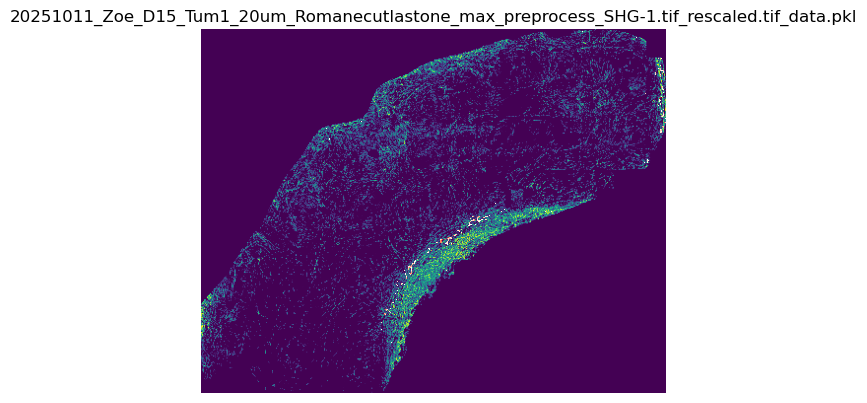

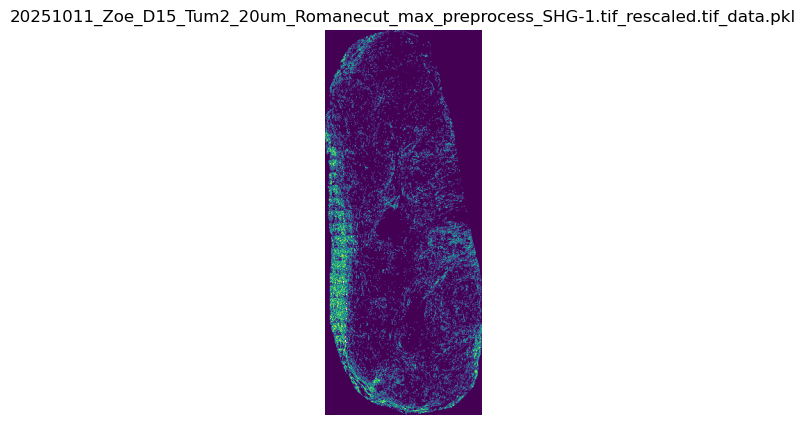

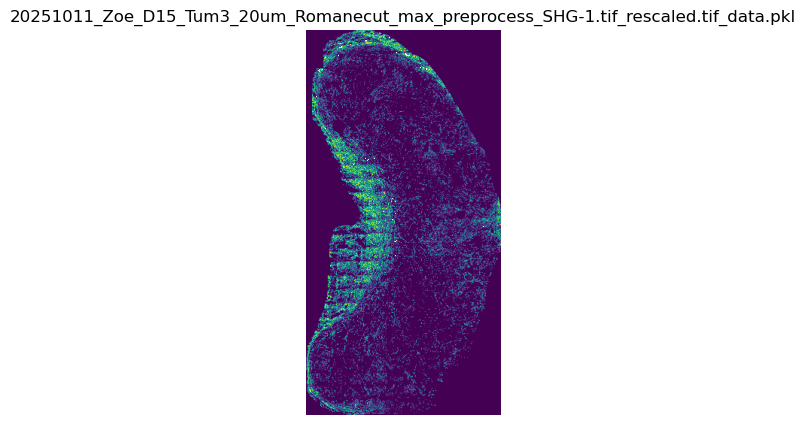

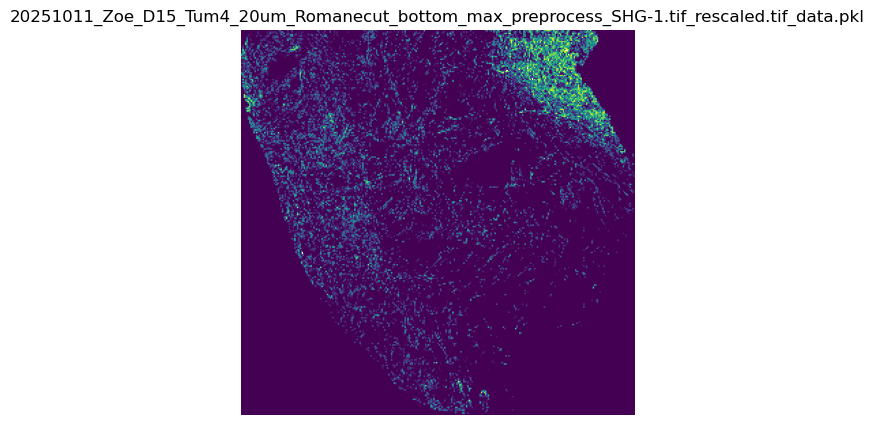

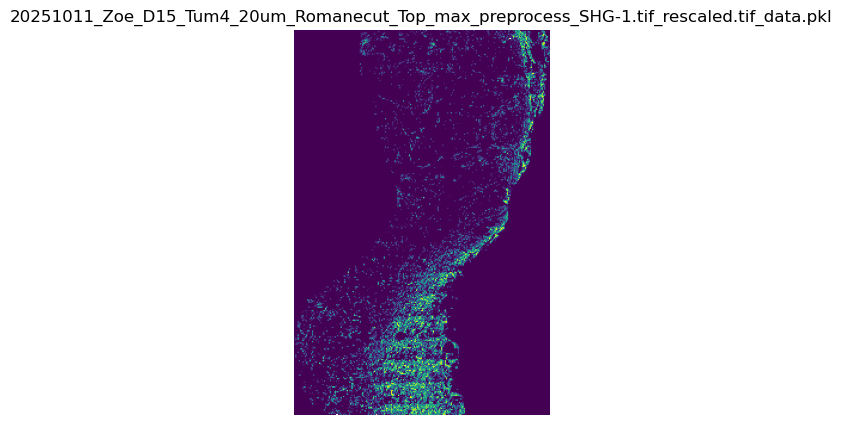

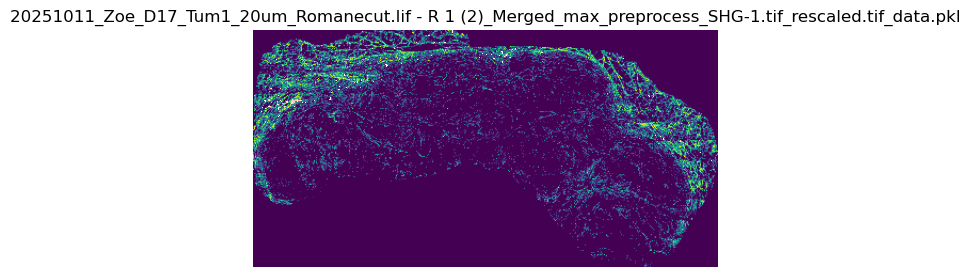

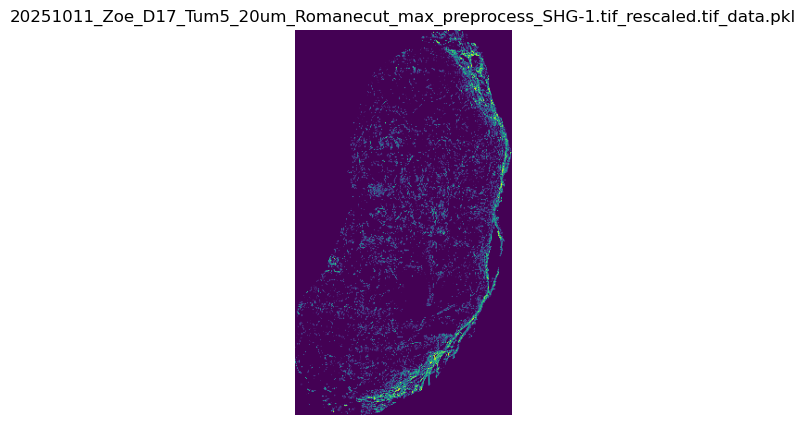

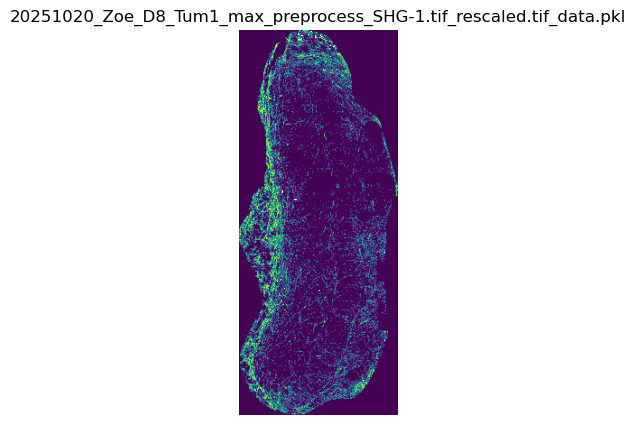

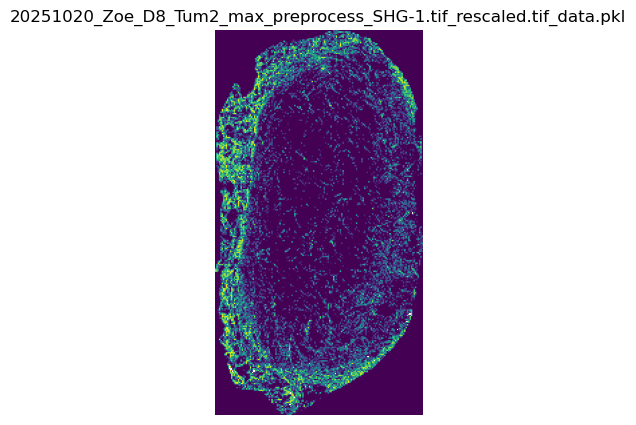

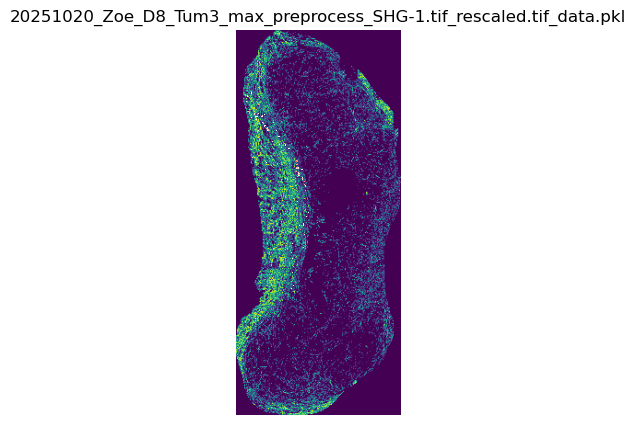

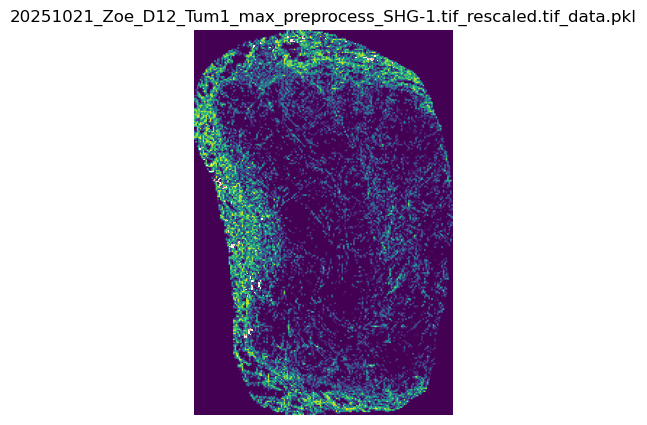

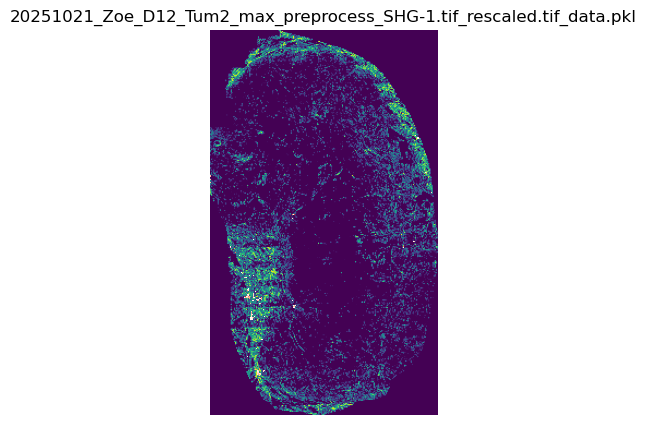

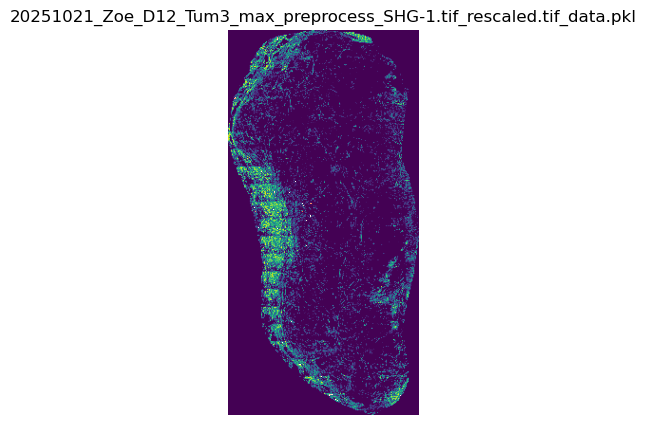

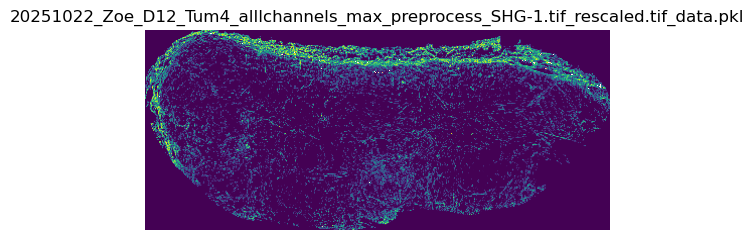

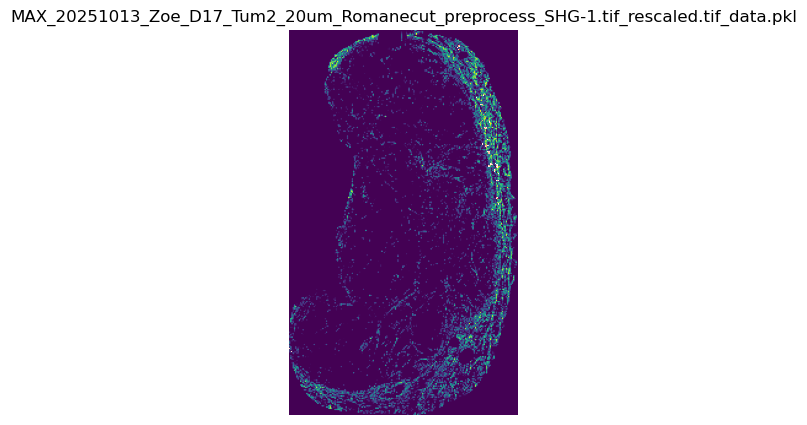

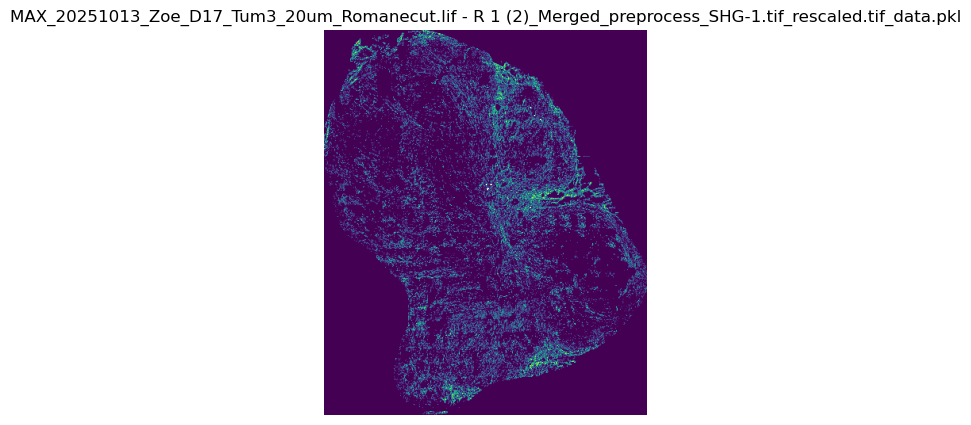

In [32]:
from src.utils import extract
import matplotlib.pyplot as plt
for i in dataframe_days["FileName"].unique():
    m = extract.extract_map(
        dataframe_days,
        "Density20",
        sample_name=i
    )
    m2 = extract.extract_map(
        dataframe_days,
        "Cells",
        sample_name=i
    )
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(m, cmap='viridis')
    ax.imshow(np.ma.masked_where(m2 <= 0, m2), cmap=plt.cm.Reds)
    ax.axis("off")
    ax.set_title(i)
    plt.savefig("results/timepoint/"+i+".png")
    plt.show()

In [34]:
features_column = FEATURES["fiber-dist-shape"]
target_column = TARGETS_COLNAMES[0]

In [37]:
# To train
x, y, groups = models.split_xy(
    df=dataframe, x_columns=features_column, y_columns=target_column, groups=SAMPLE_GROUP
)
# To Pred
x_days, y_days, groups_days = models.split_xy(
    df=dataframe_days, x_columns=features_column, y_columns=target_column, groups=SAMPLE_GROUP
)

In [38]:
estimator_param = {'n_estimators': 32,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': True}

In [39]:
estimator = RandomForestClassifier(**estimator_param, random_state=SEED)
estimator.fit(x, y.ravel())

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_split=8, n_estimators=32,
                       random_state=42)

(<Figure size 1000x900 with 2 Axes>,
 <Axes: xlabel='Predicted label', ylabel='True label'>)

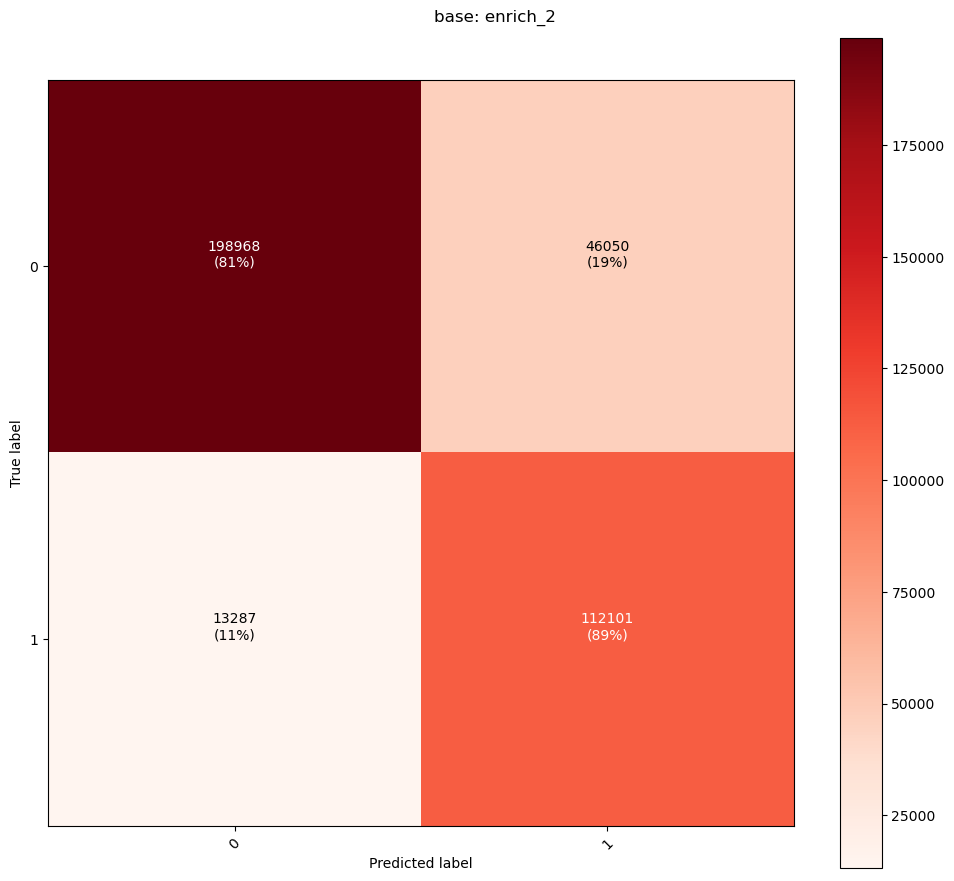

In [40]:
observed_train, predicted_train = models.predict_model(x, y, estimator)
display.display_confusion_matrix(
    observed=observed_train, predicted=predicted_train, cmap="Reds",
    labels=None, filepath="results/timepoint/base-confusion_matrix.png", title=f"base: {target_column}"
)

(<Figure size 1000x900 with 2 Axes>,
 <Axes: xlabel='Predicted label', ylabel='True label'>)

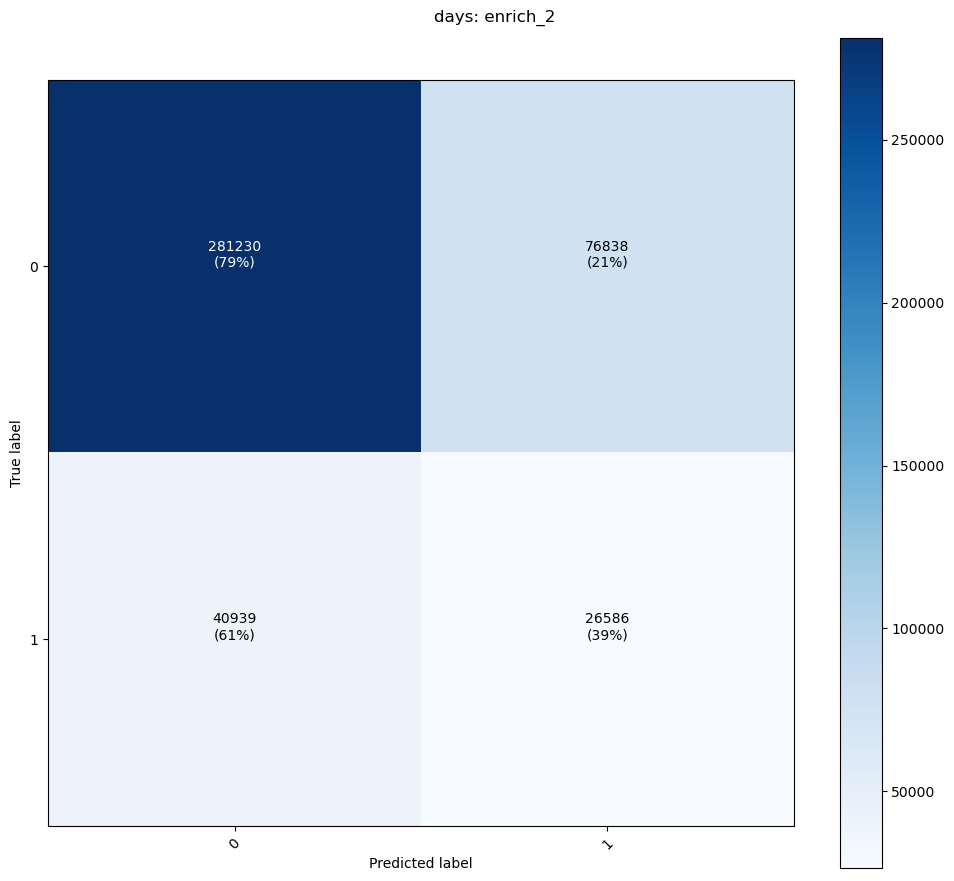

In [41]:
observed_days, predicted_days = models.predict_model(x_days, y_days, estimator)
display.display_confusion_matrix(
    observed=observed_days, predicted=predicted_days, cmap="Blues",
    labels=None, filepath="results/timepoint/time-confusion_matrix.png", title=f"days: {target_column}"
)

In [ ]:
scores = models.scorer_model(
    estimator=estimator,
    x=x_days, y=y_days, scorer=SCORING_base
)
scores

{'accuracy': [0.7232637754850291],
 'balanced_accuracy': [0.5895651597134992],
 'precision': [0.25705832301980197],
 'recall': [0.393720844131803],
 'auc': [0.5895651597134991],
 'mcc': [0.1525919462372716],
 'f1': [0.3110401347770388]}

DAY= D12 {'accuracy': [0.7230232657054145], 'balanced_accuracy': [0.6292562666923229], 'precision': [0.35012945628360886], 'recall': [0.47454516007126274], 'auc': [0.6292562666923228], 'mcc': [0.23241199063837878], 'f1': [0.4029522325112313]}
DAY= D15 {'accuracy': [0.7223736871793495], 'balanced_accuracy': [0.5573079740342569], 'precision': [0.20403897671406282], 'recall': [0.3263797325296666], 'auc': [0.5573079740342569], 'mcc': [0.09551083565714961], 'f1': [0.2511004438003804]}
DAY= D17 {'accuracy': [0.6269305770445578], 'balanced_accuracy': [0.5488002548944935], 'precision': [0.2431120053655265], 'recall': [0.41955646094726606], 'auc': [0.5488002548944935], 'mcc': [0.08198964711082489], 'f1': [0.3078438699595747]}
DAY= D8 {'accuracy': [0.8687264999182606], 'balanced_accuracy': [0.606976682890391], 'precision': [0.2548409893992933], 'recall': [0.29236257499594615], 'auc': [0.606976682890391], 'mcc': [0.2011153939498767], 'f1': [0.2723153602174898]}


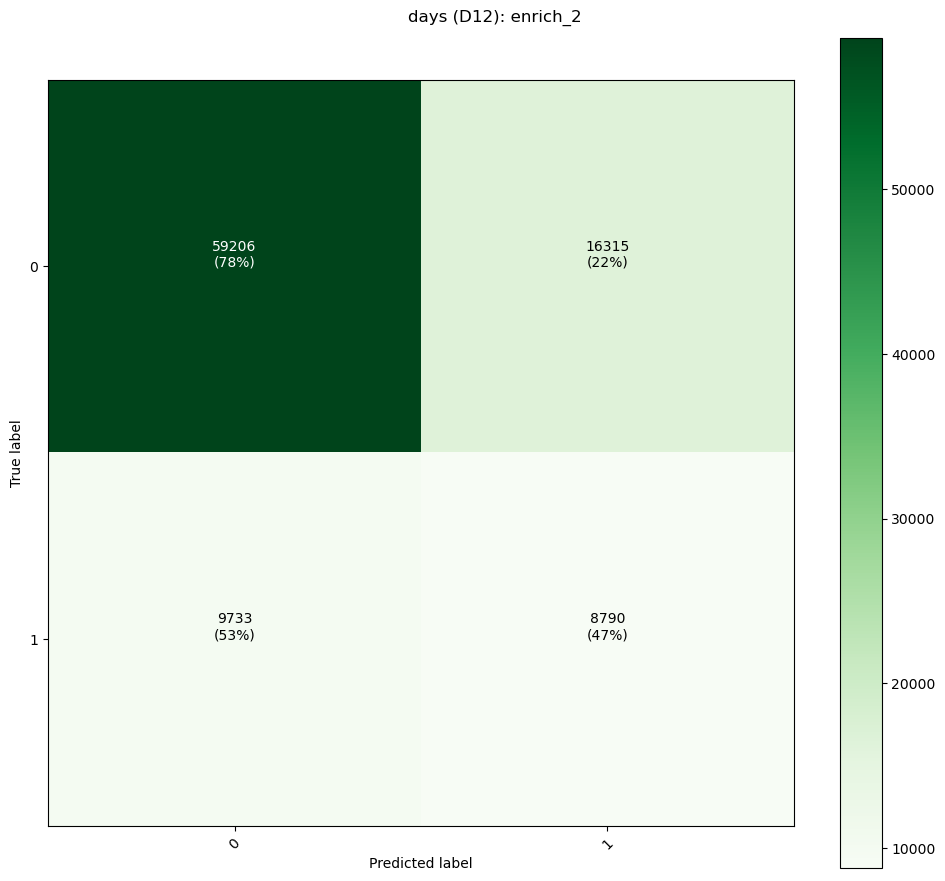

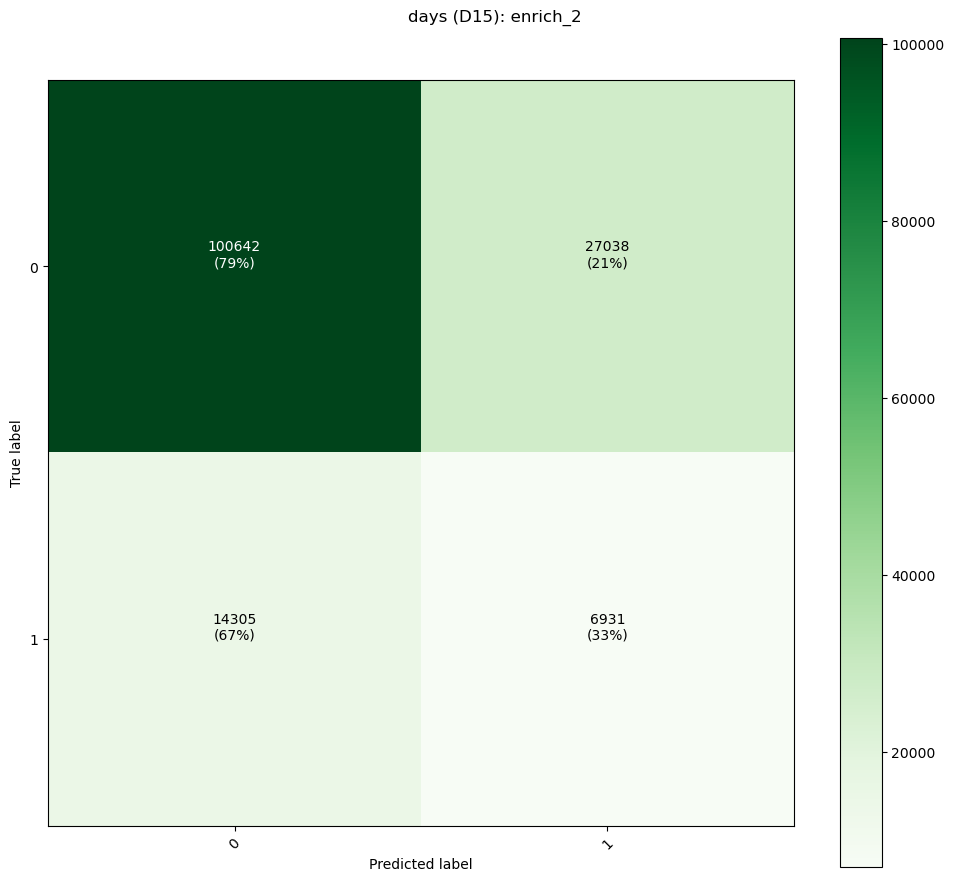

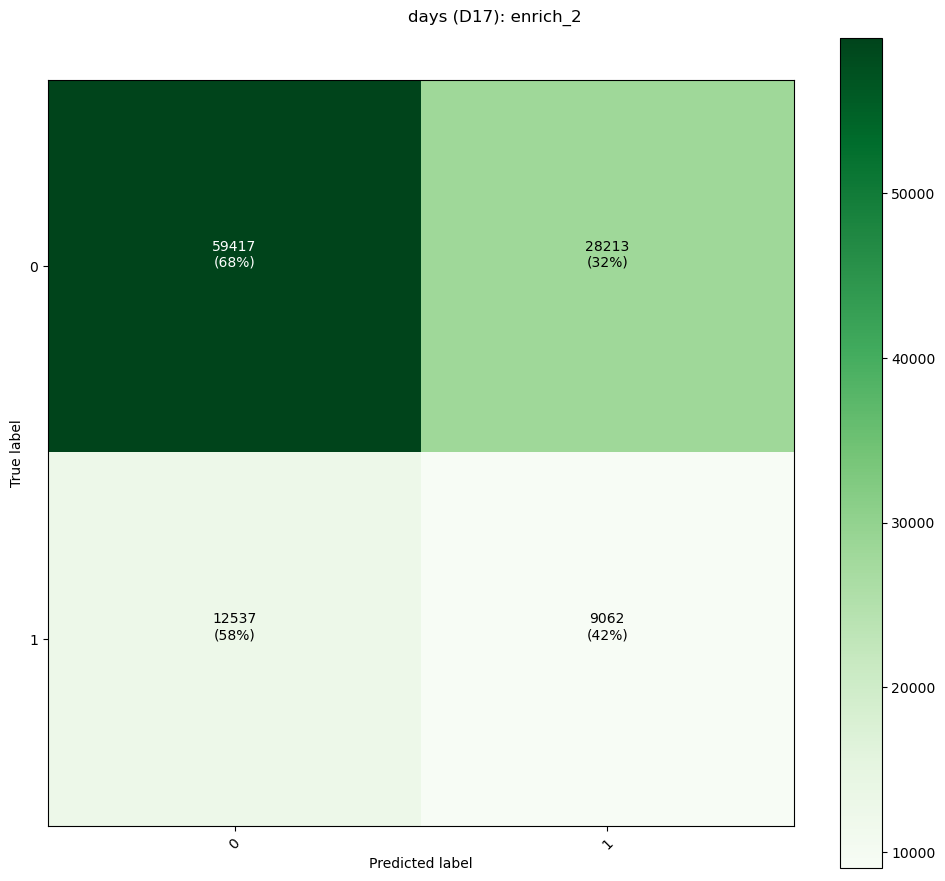

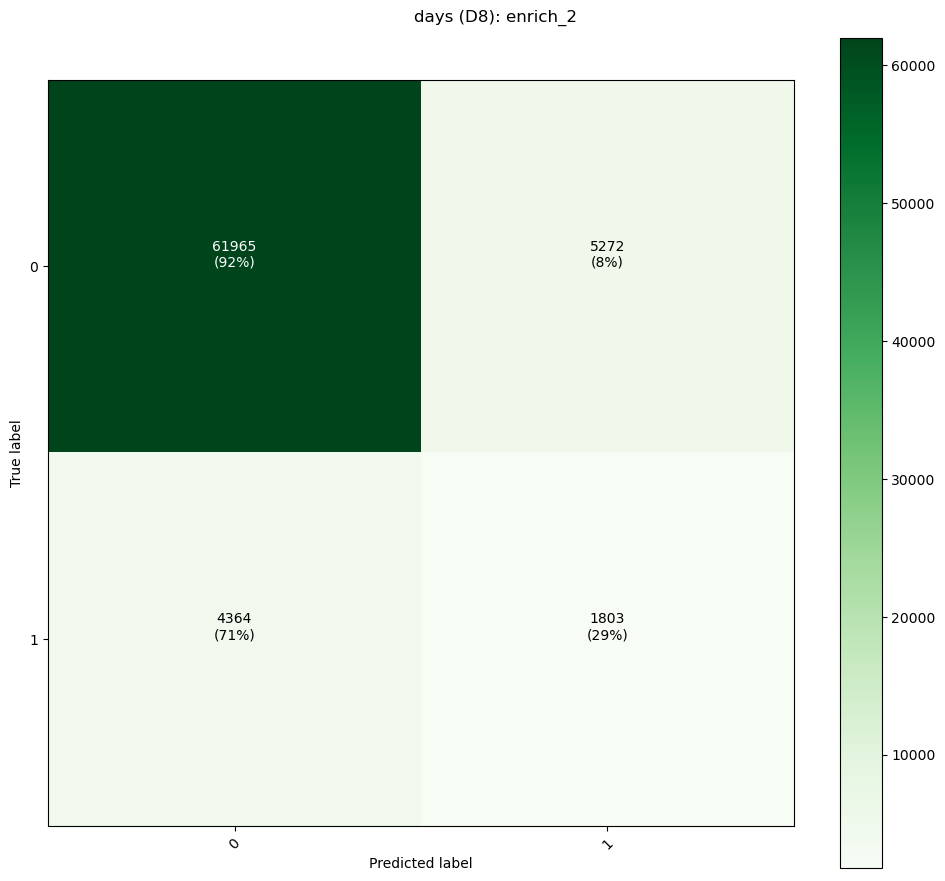

In [ ]:
for cond_name, obs in dataframe_days.sort_values(by="TimeCondition").reset_index().groupby("TimeCondition"):
    idx = obs.index.to_numpy()
    display.display_confusion_matrix(
        observed=observed_days[idx], predicted=predicted_days[idx], cmap="Greens",
        labels=None, filepath=f"results/timepoint/time-{cond_name}_confusion_matrix.png", title=f"days ({cond_name}): {target_column}"
    )
    scores = models.scorer_model(
        estimator=estimator,
        x=x_days[idx], y=y_days[idx], scorer=SCORING_base
    )
    print("DAY=", cond_name, scores)

TRAIN 0.7/DAY = D12 {'accuracy': [0.8101929211605651], 'balanced_accuracy': [0.7963903403643366], 'precision': [0.477540870853394], 'recall': [0.775030053237163], 'auc': [0.7963903403643368], 'mcc': [0.4999826387240195], 'f1': [0.5909581955674862]}
TEST 0.3/DAY = D12 {'accuracy': [0.784575033671227], 'balanced_accuracy': [0.7424614806996681], 'precision': [0.4308103975535168], 'recall': [0.6772836538461539], 'auc': [0.7424614806996681], 'mcc': [0.4129785361274459], 'f1': [0.5266355140186916]}
TRAIN 0.7/DAY = D15 {'accuracy': [0.8253086597404092], 'balanced_accuracy': [0.8195590046713846], 'precision': [0.4893989296006587], 'recall': [0.8108799454297408], 'auc': [0.8195590046713846], 'mcc': [0.5333549538612601], 'f1': [0.610397946084724]}
TEST 0.3/DAY = D15 {'accuracy': [0.8035142697257974], 'balanced_accuracy': [0.7804988269554879], 'precision': [0.45041653316244795], 'recall': [0.7457559681697613], 'auc': [0.7804988269554878], 'mcc': [0.46826782492681596], 'f1': [0.5616260487415102]}


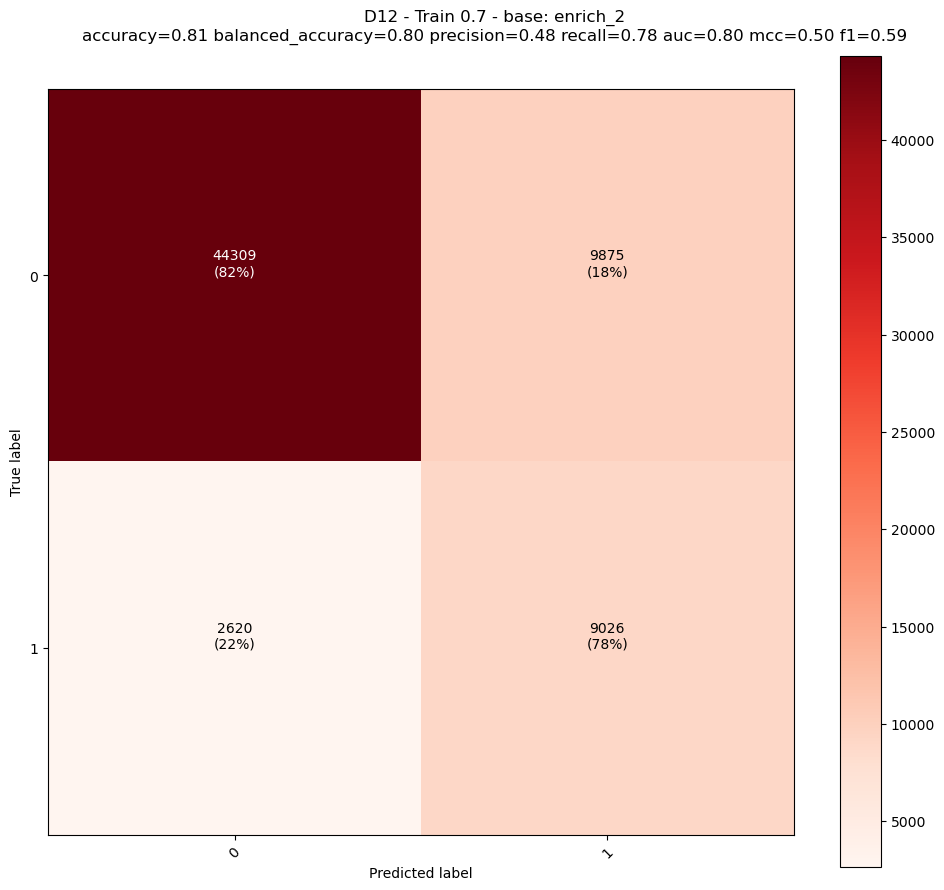

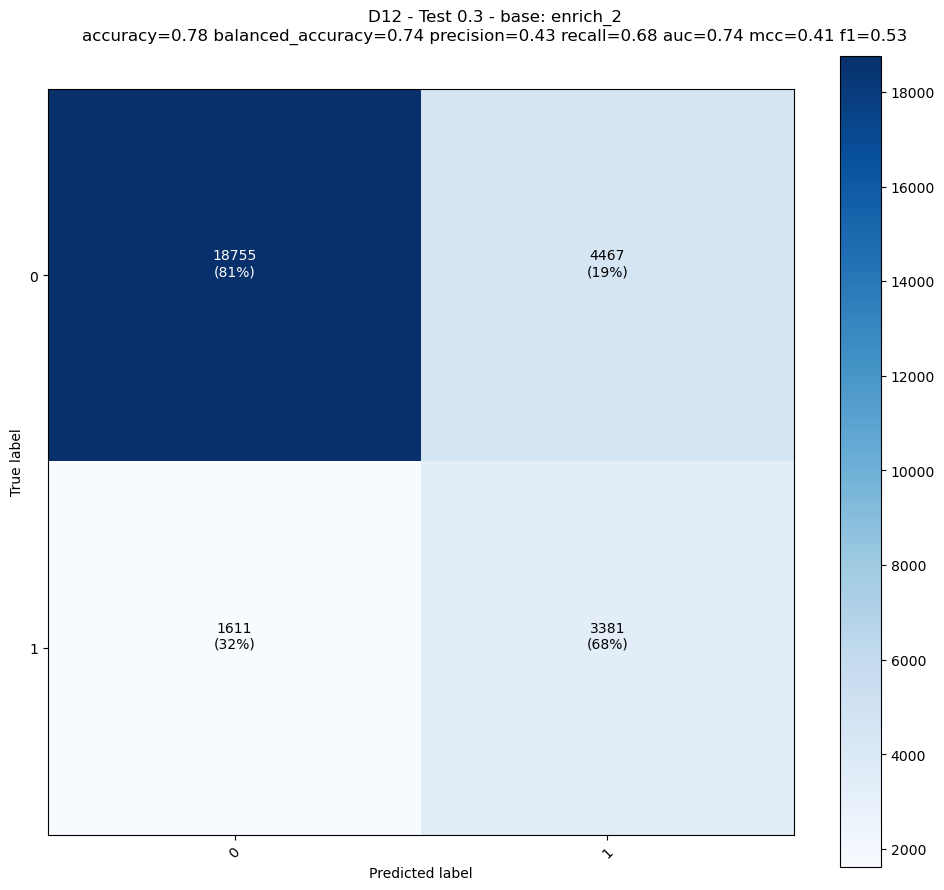

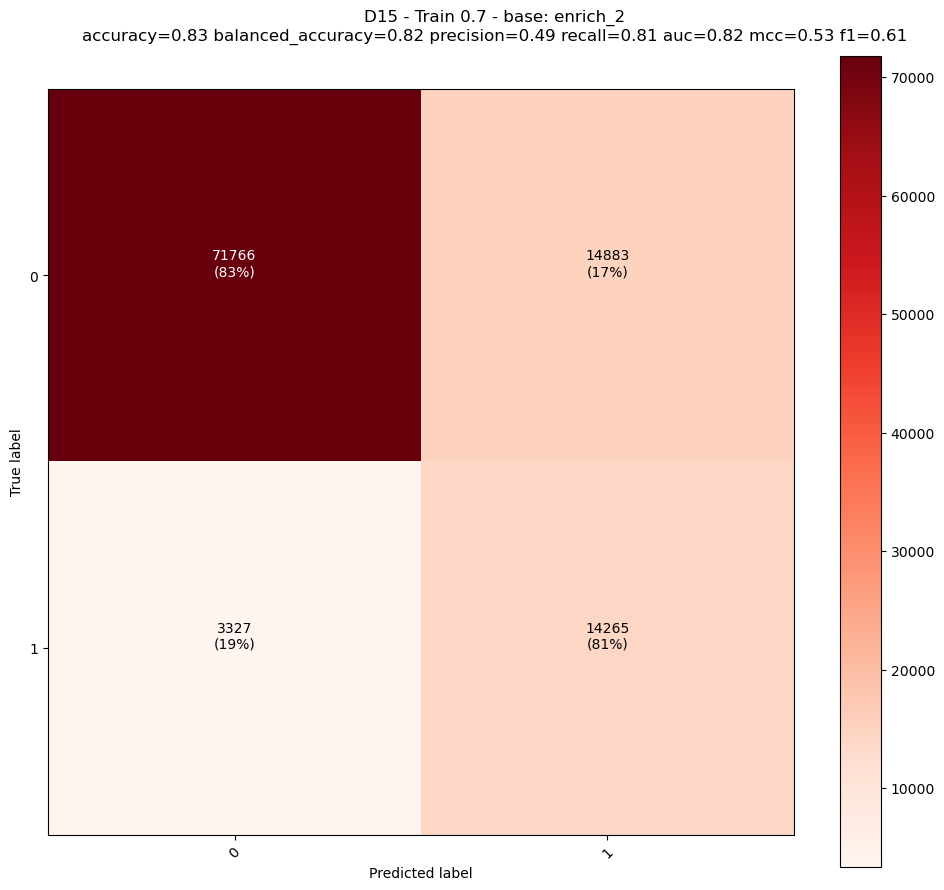

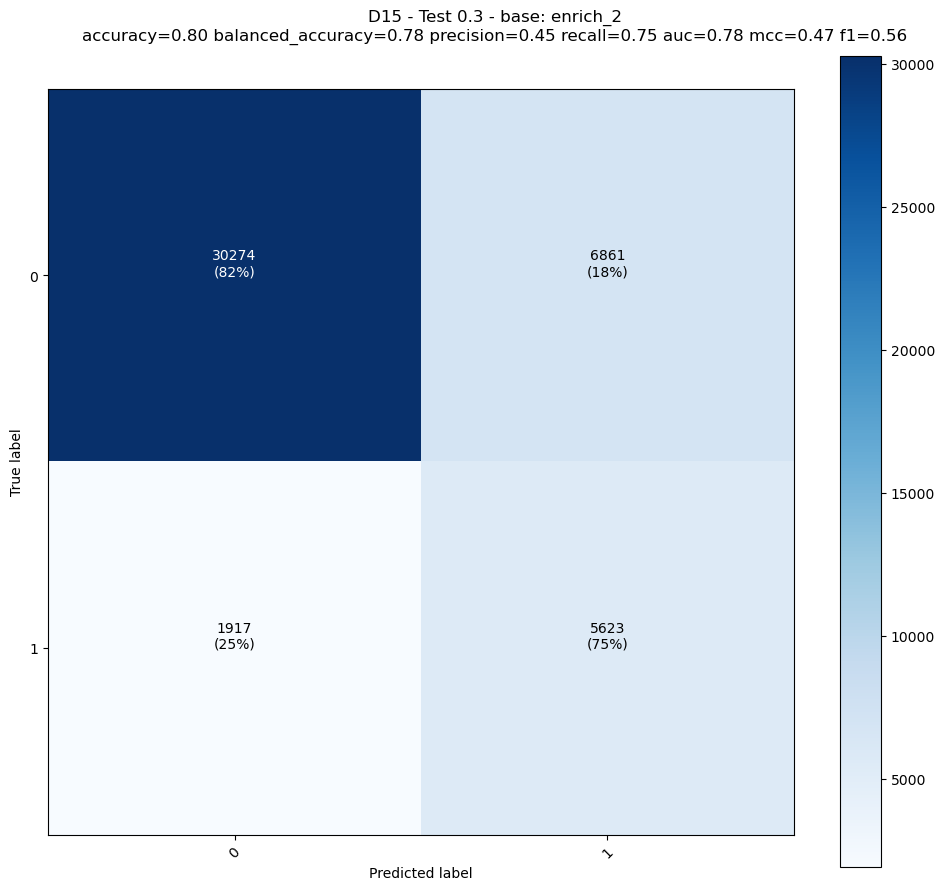

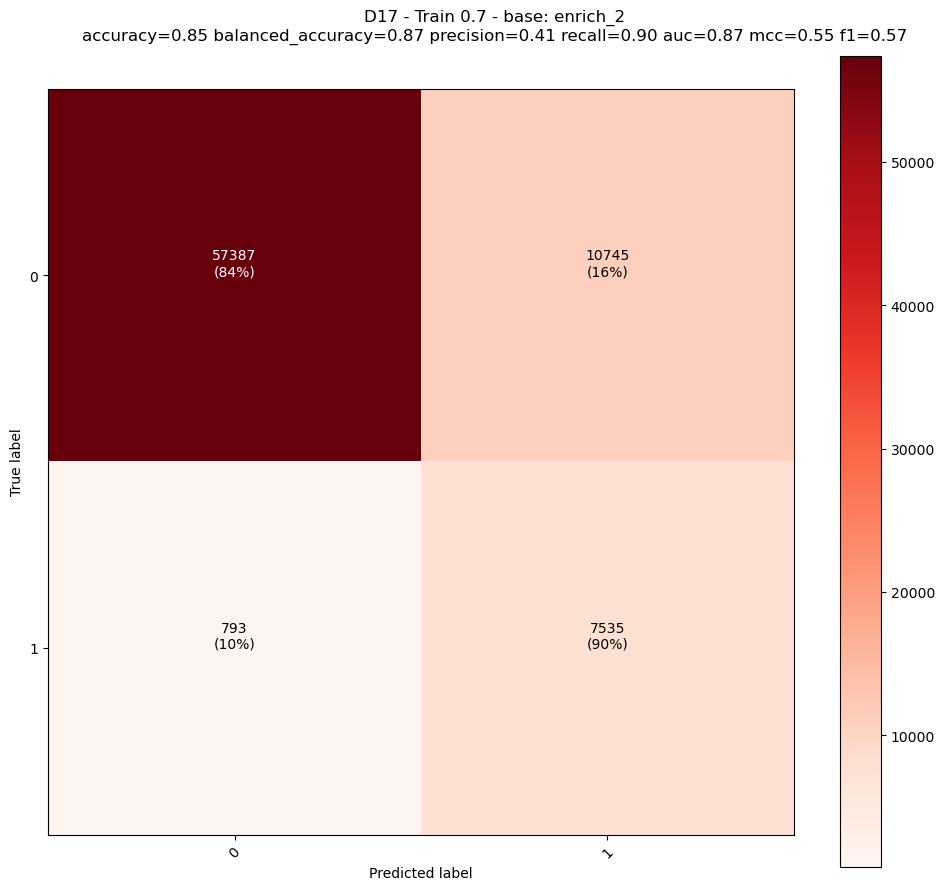

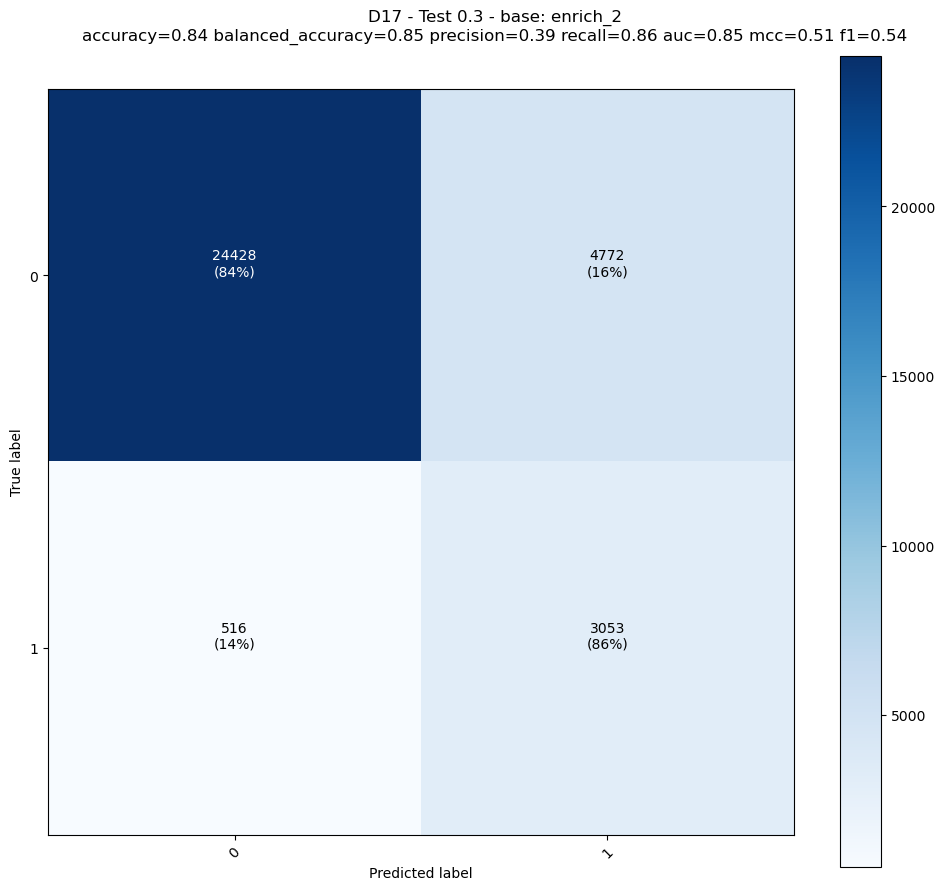

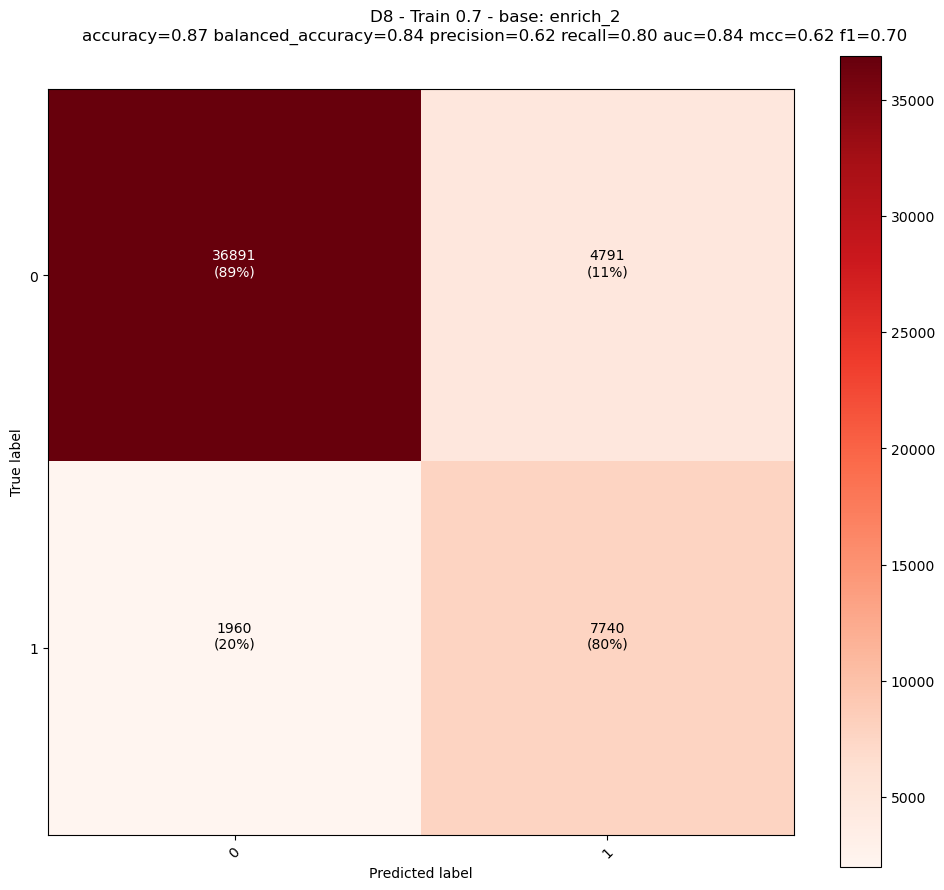

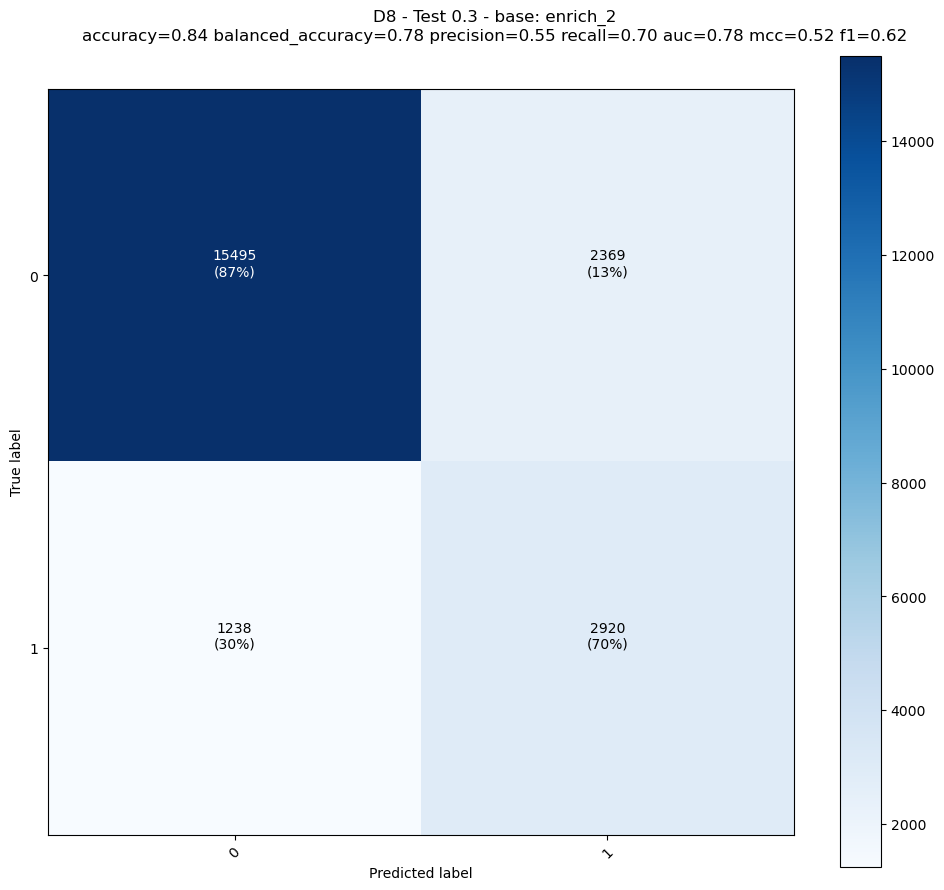

In [69]:
from sklearn.model_selection import train_test_split
models_t = dict()
scores_t = dict()
for condition_name, obs in dataframe_days.reset_index().groupby("TimeCondition"):
    # To Pred
    x_t, y_t, groups_t = models.split_xy(
        df=obs, x_columns=features_column, y_columns=target_column, groups=SAMPLE_GROUP
    )
    x_t_train, x_t_test, y_t_train, y_t_test = train_test_split(
        x_t, y_t, test_size=0.3, random_state=SEED, stratify=obs["enrich_2"]
    )
    estimator_t = RandomForestClassifier(**estimator_param, random_state=SEED)
    estimator_t.fit(x_t_train, y_t_train.ravel())
    obs_train, pred_train = models.predict_model(x_t_train, y_t_train, estimator_t)
    obs_test, pred_test = models.predict_model(x_t_test, y_t_test, estimator_t)
    # Metrics
    scores_t_train = models.scorer_model(
        estimator=estimator_t, x=x_t_train, y=y_t_train, scorer=SCORING_base
    )
    scores_t_test = models.scorer_model(
        estimator=estimator_t, x=x_t_test, y=y_t_test, scorer=SCORING_base
    )
    scores_t = {
        **scores_t,
        **{f"train_0.7_{k}": v for k, v in scores_t_train.items()},
        **{f"test_0.3_{k}": v for k, v in scores_t_test.items()}
    }
    score_t_train_print = " ".join([f"{k}={v[0]:.2f}" for k,v in scores_t_train.items()])
    score_t_test_print = " ".join([f"{k}={v[0]:.2f}" for k,v in scores_t_test.items()])
    print("TRAIN 0.7/DAY =", condition_name, scores_t_train)
    print("TEST 0.3/DAY =", condition_name, scores_t_test)
    display.display_confusion_matrix(
        observed=y_t_train, predicted=pred_train, cmap="Reds",
        labels=None, filepath=f"results/timepoint/train-test/{condition_name}_base-confusion_matrix_on_train.png",
        title=f"{condition_name} - Train 0.7 - base: {target_column}\n{score_t_train_print}"
    )
    display.display_confusion_matrix(
        observed=y_t_test, predicted=pred_test, cmap="Blues",
        labels=None, filepath=f"results/timepoint/train-test/{condition_name}_base-confusion_matrix_on_test.png",
        title=f"{condition_name} - Test 0.3 - base: {target_column}\n{score_t_test_print}"
    )
    #
    models_t[condition_name] = estimator_t.fit(x_t, y_t.ravel())

Train on D8 pred on D8/ accuracy=0.85 balanced_accuracy=0.83 precision=0.58 recall=0.79 auc=0.83 mcc=0.59 f1=0.67
Train on D8 pred on D12/ accuracy=0.72 balanced_accuracy=0.54 precision=0.23 recall=0.26 auc=0.54 mcc=0.07 f1=0.25
Train on D8 pred on D15/ accuracy=0.75 balanced_accuracy=0.53 precision=0.22 recall=0.19 auc=0.53 mcc=0.06 f1=0.21
Train on D8 pred on D17/ accuracy=0.83 balanced_accuracy=0.56 precision=0.22 recall=0.21 auc=0.56 mcc=0.12 f1=0.22
Train on D12 pred on D8/ accuracy=0.77 balanced_accuracy=0.53 precision=0.27 recall=0.15 auc=0.53 mcc=0.07 f1=0.19
Train on D12 pred on D12/ accuracy=0.81 balanced_accuracy=0.79 precision=0.47 recall=0.77 auc=0.79 mcc=0.49 f1=0.59
Train on D12 pred on D15/ accuracy=0.77 balanced_accuracy=0.55 precision=0.27 recall=0.23 auc=0.55 mcc=0.11 f1=0.25
Train on D12 pred on D17/ accuracy=0.86 balanced_accuracy=0.57 precision=0.29 recall=0.20 auc=0.57 mcc=0.17 f1=0.24
Train on D15 pred on D8/ accuracy=0.73 balanced_accuracy=0.54 precision=0.26 r

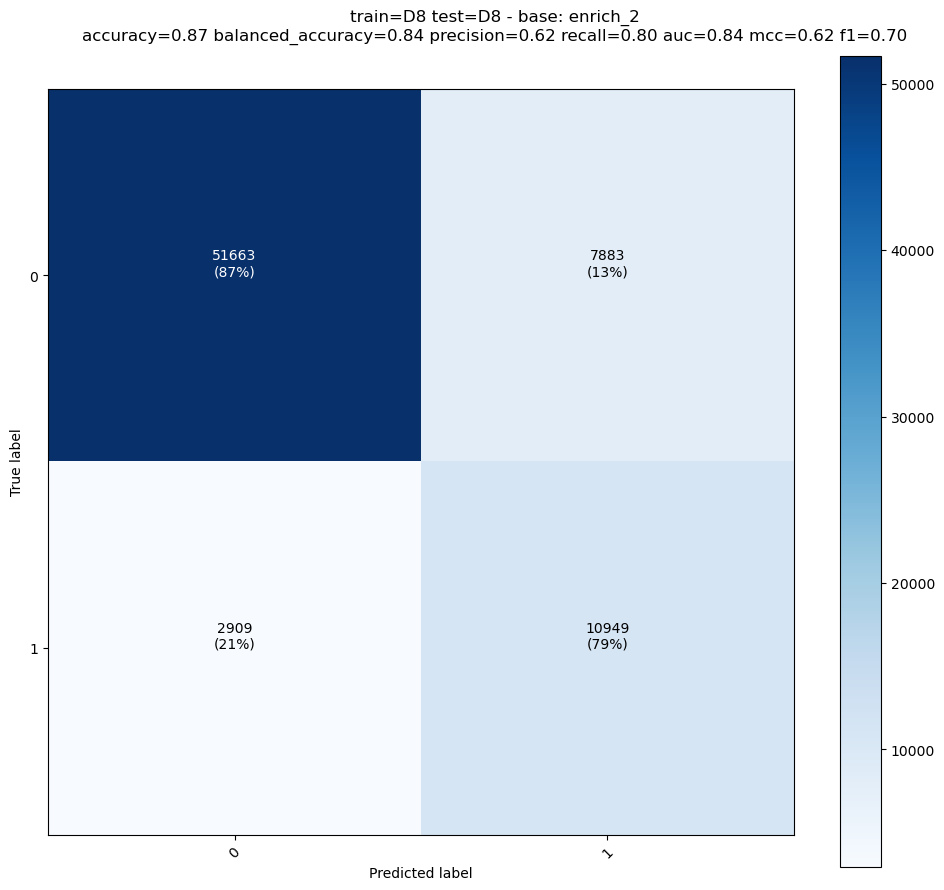

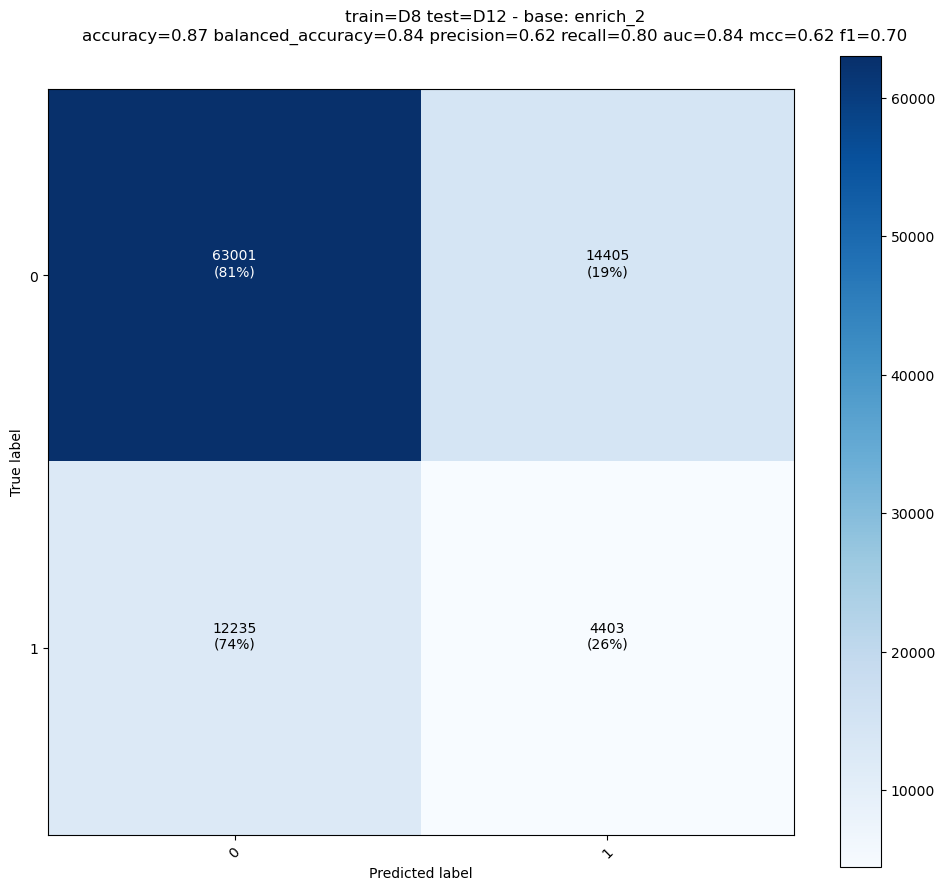

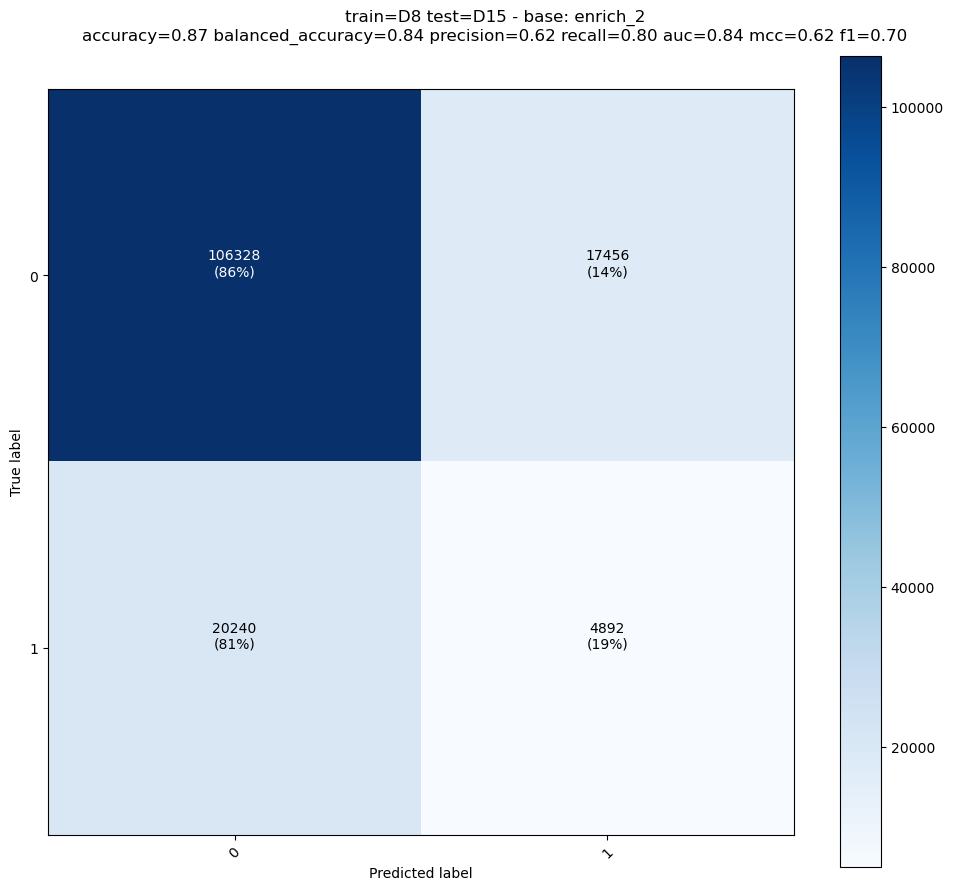

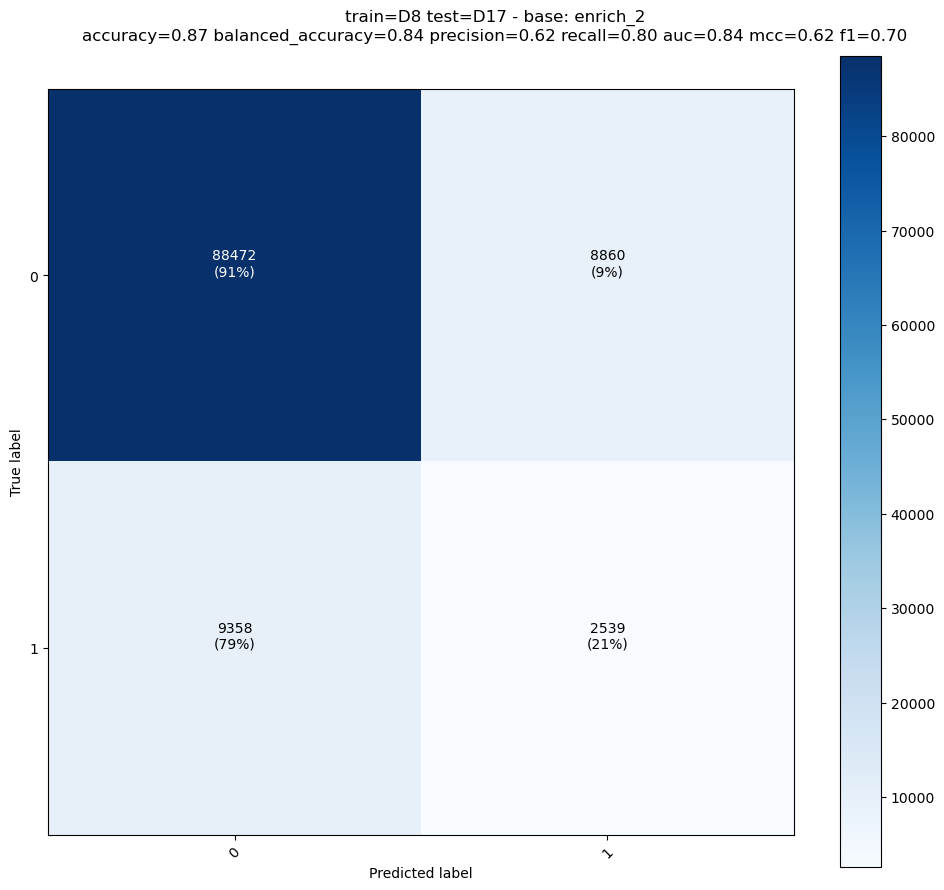

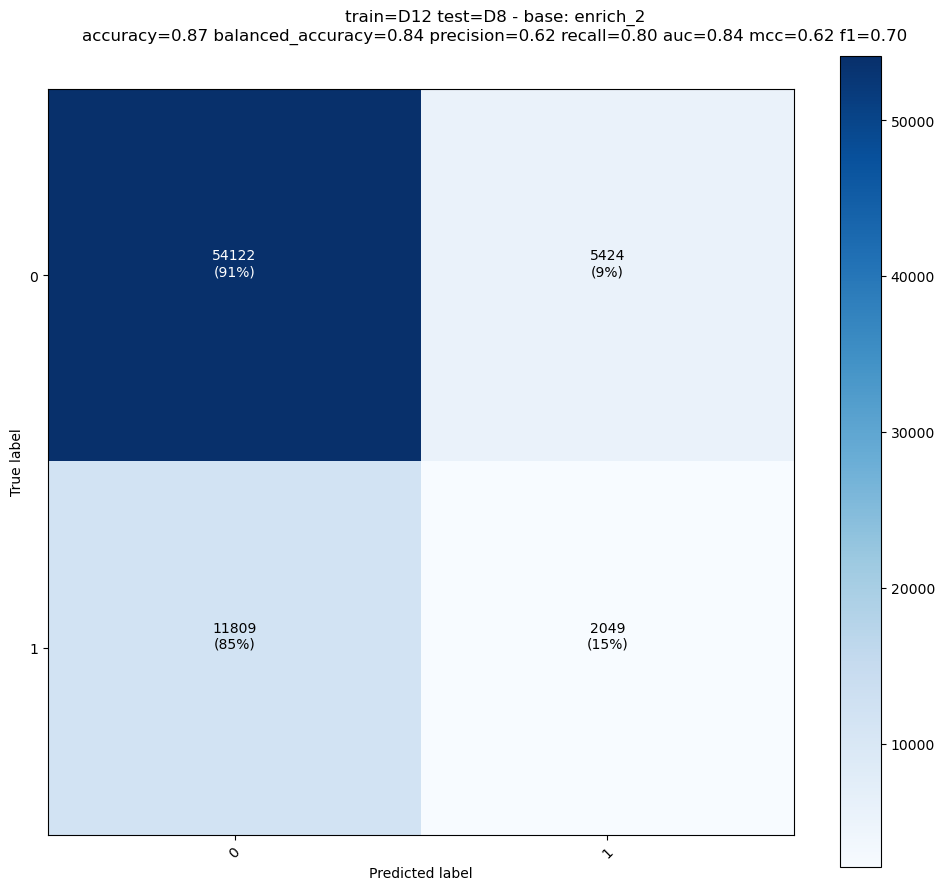

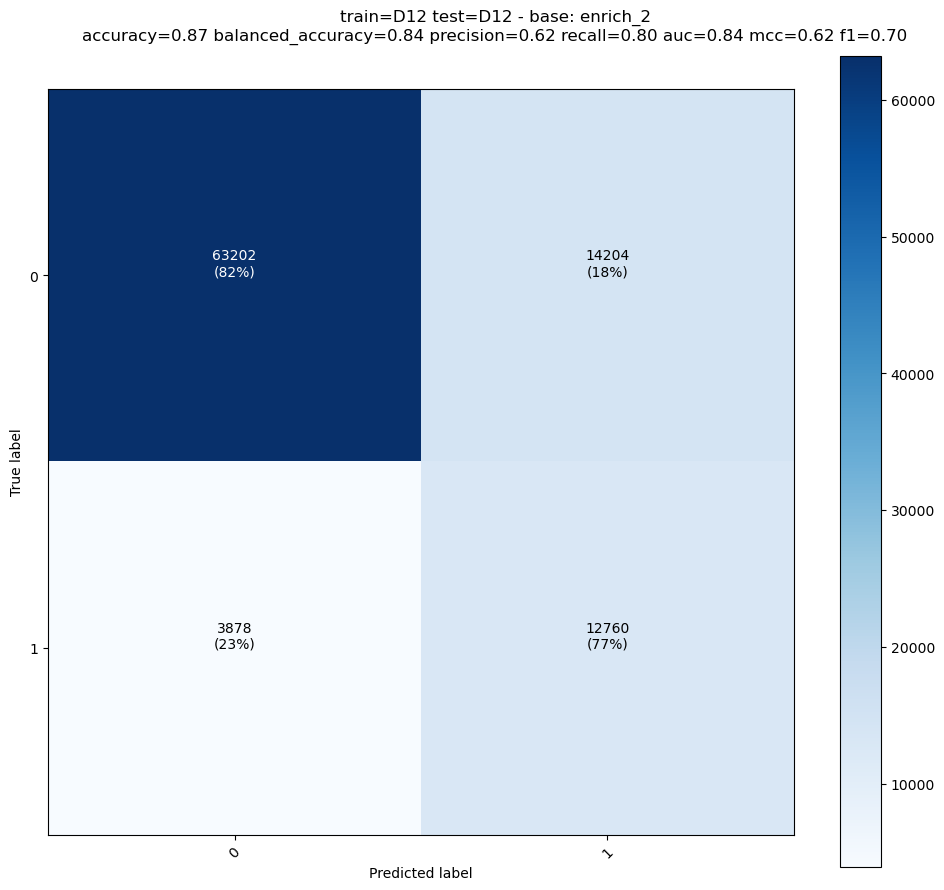

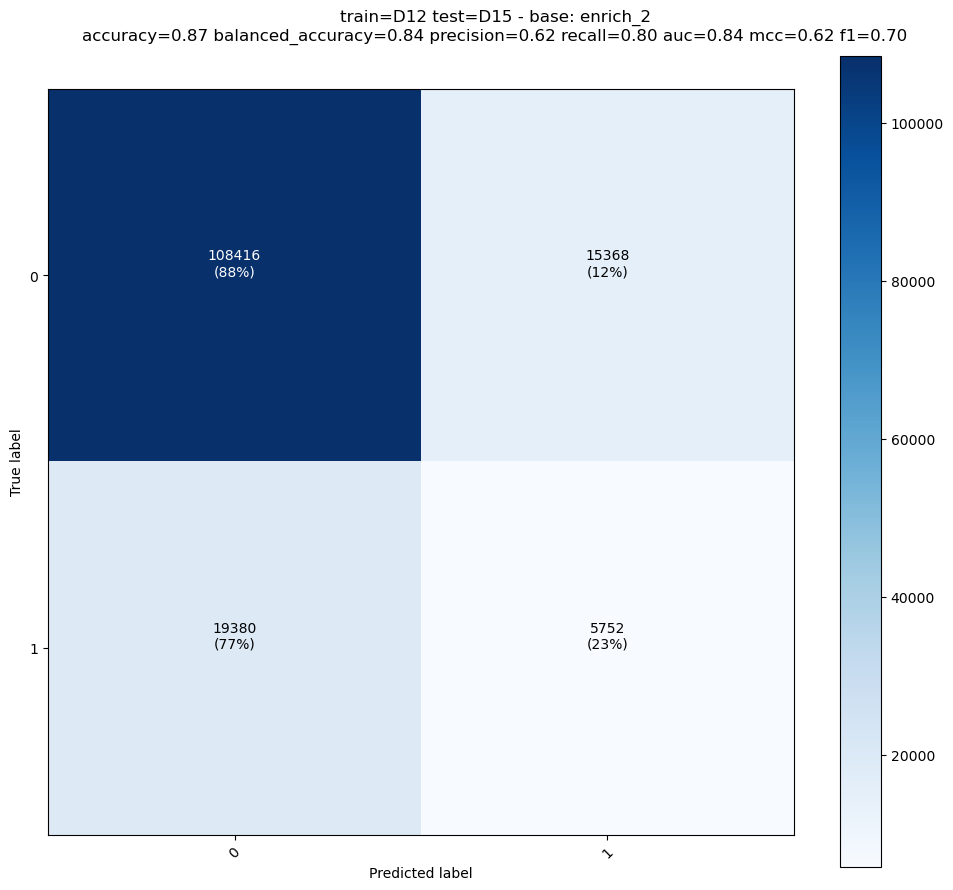

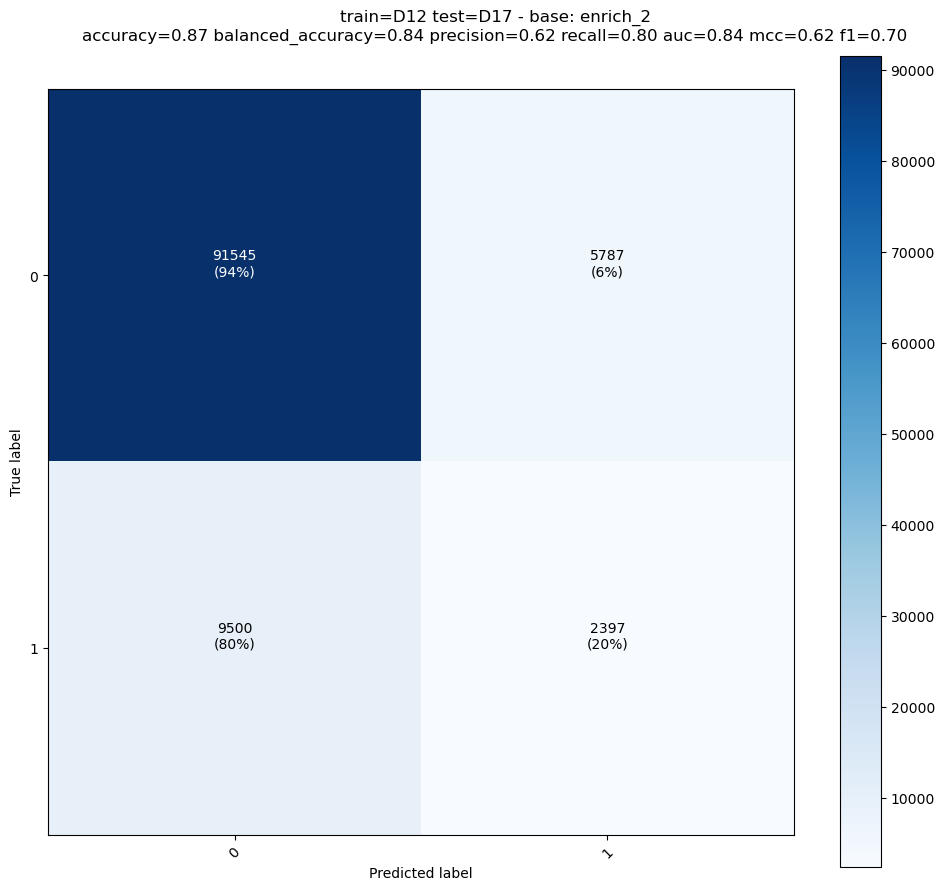

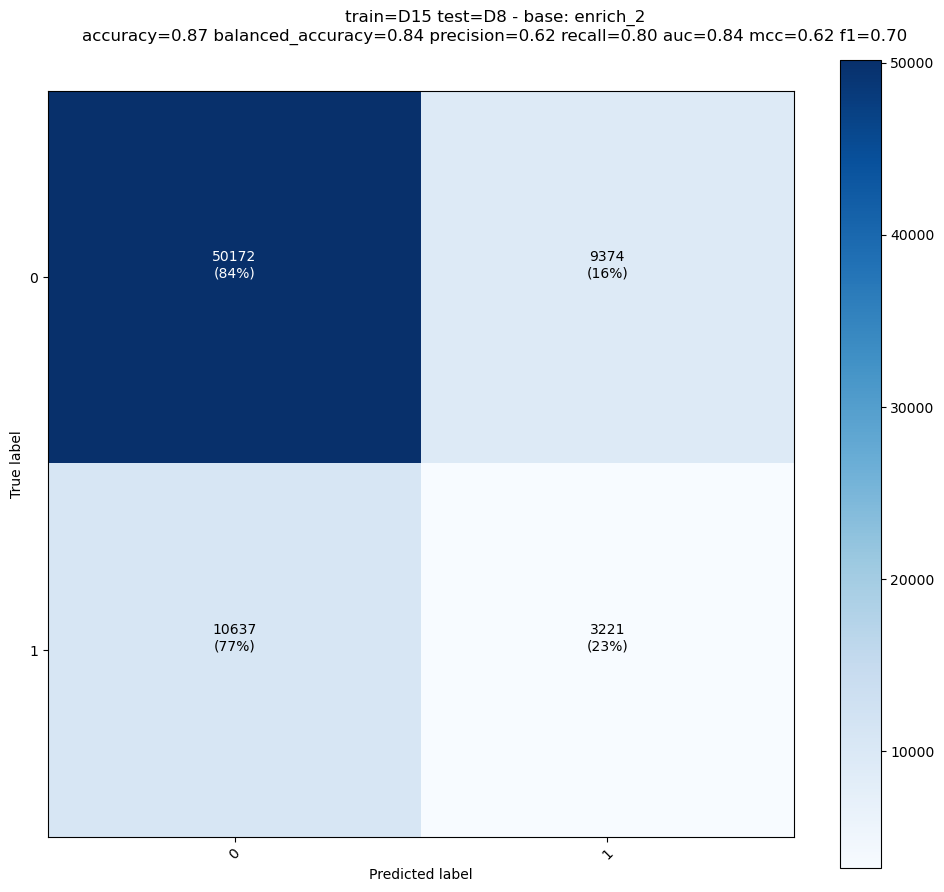

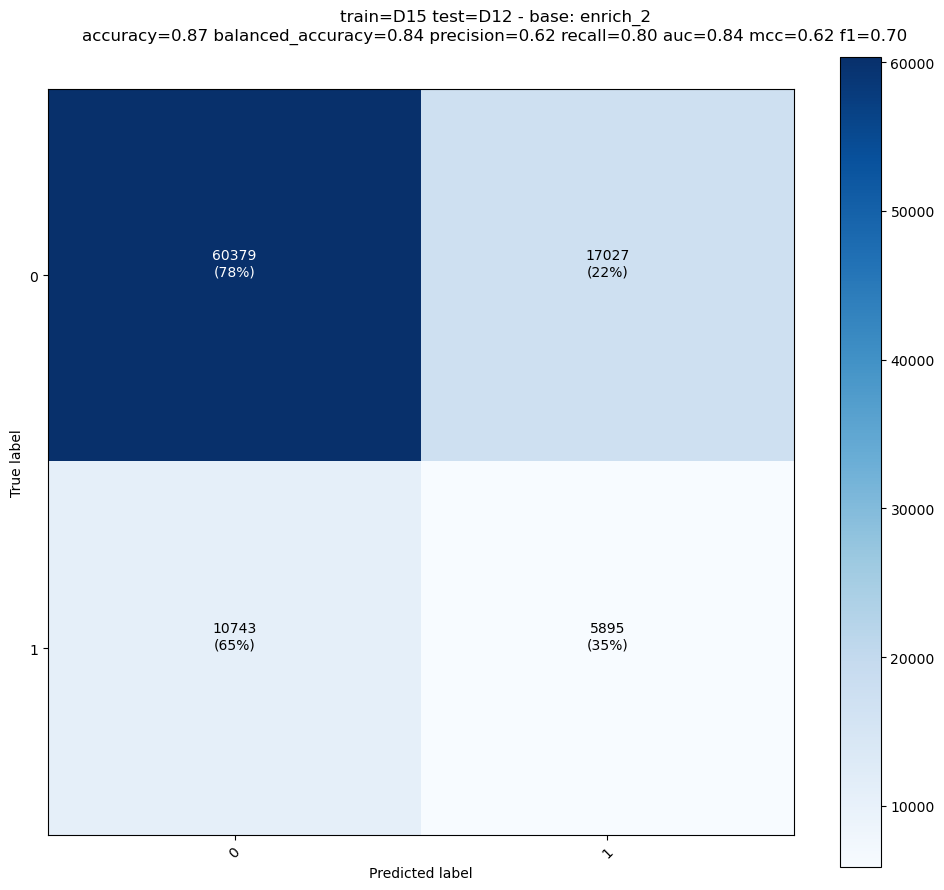

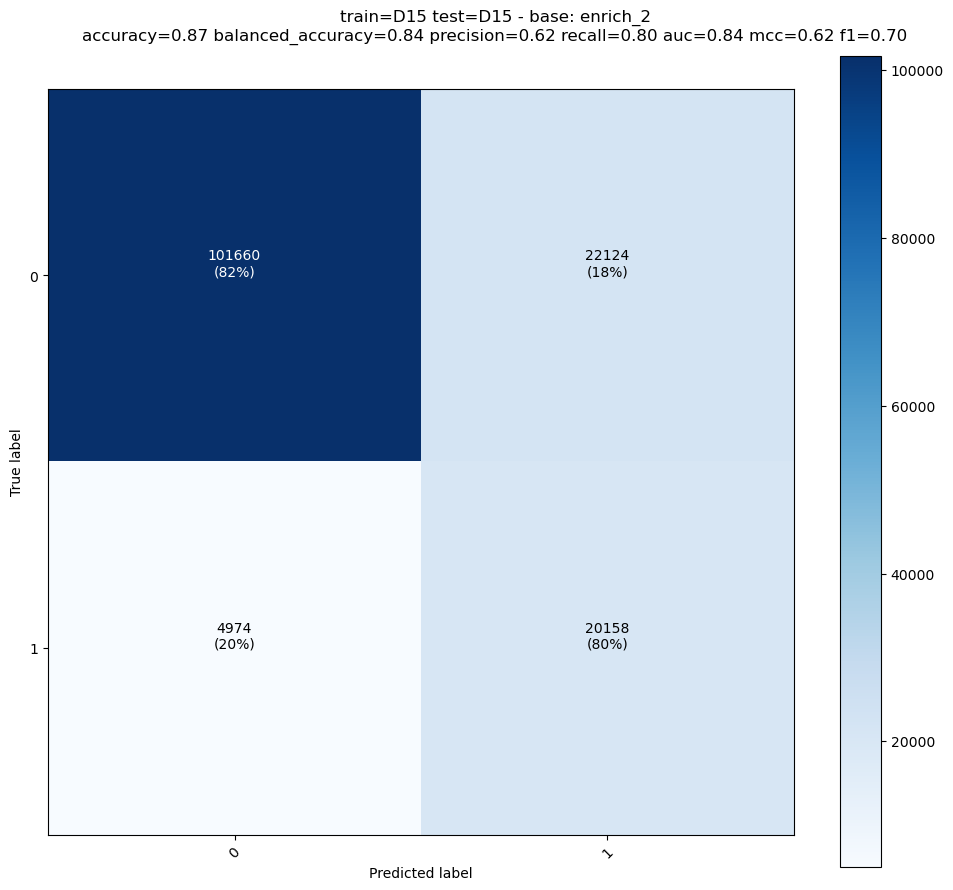

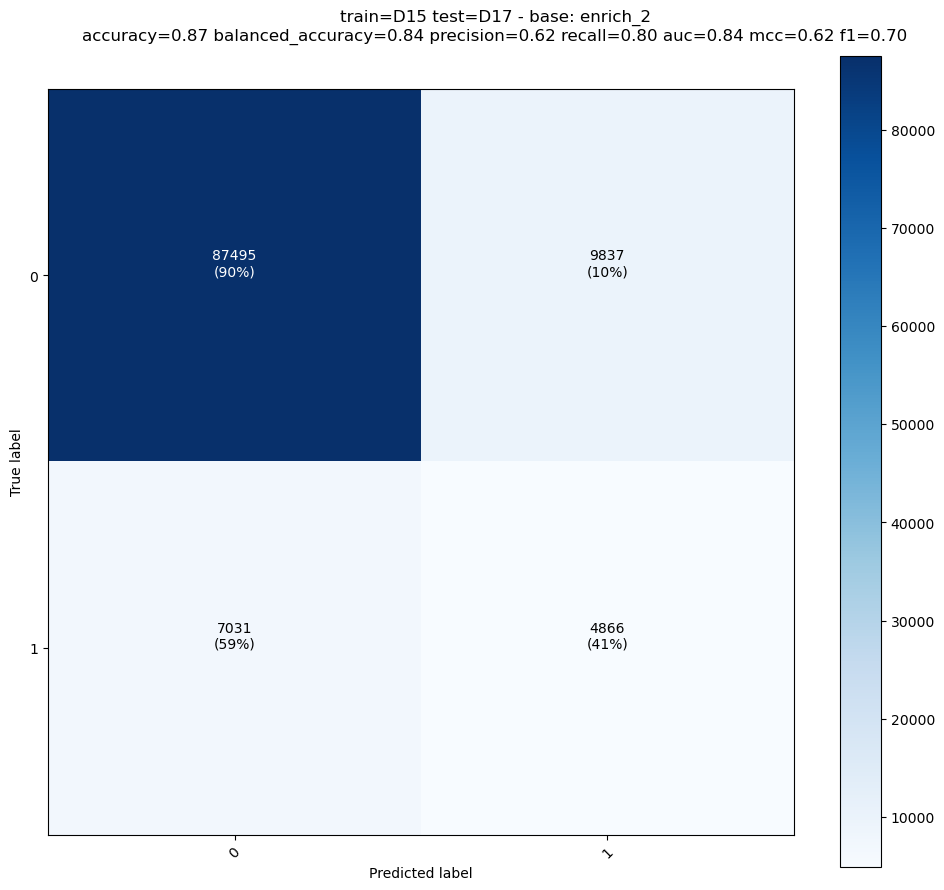

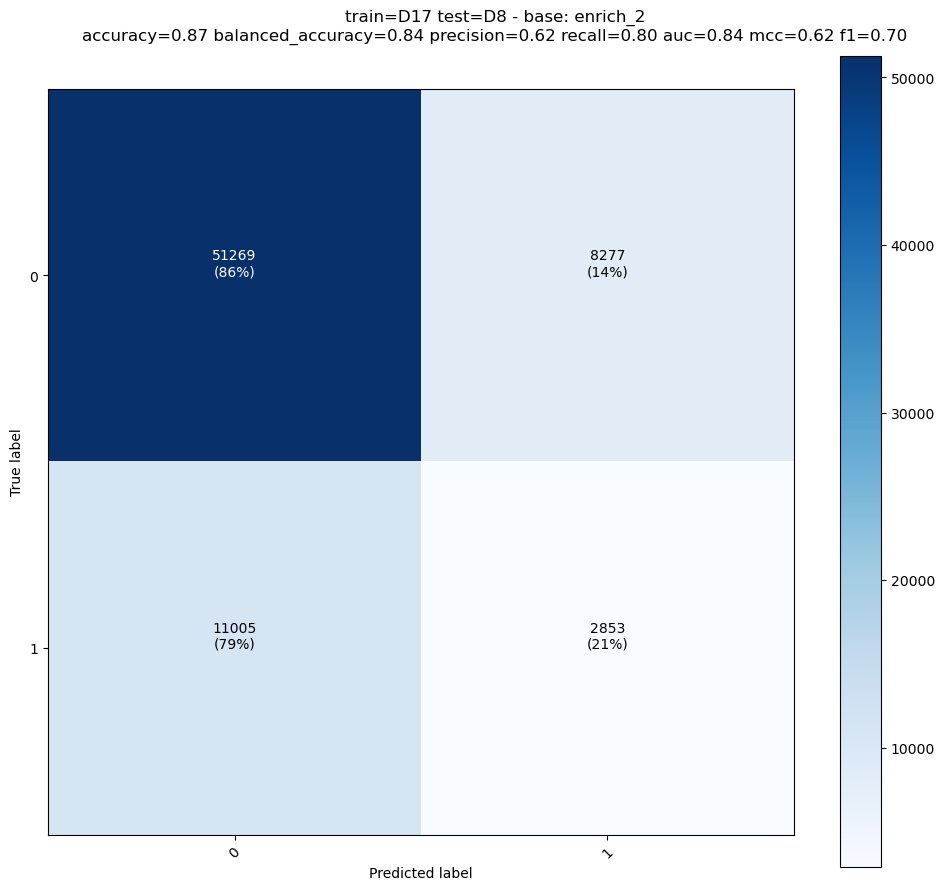

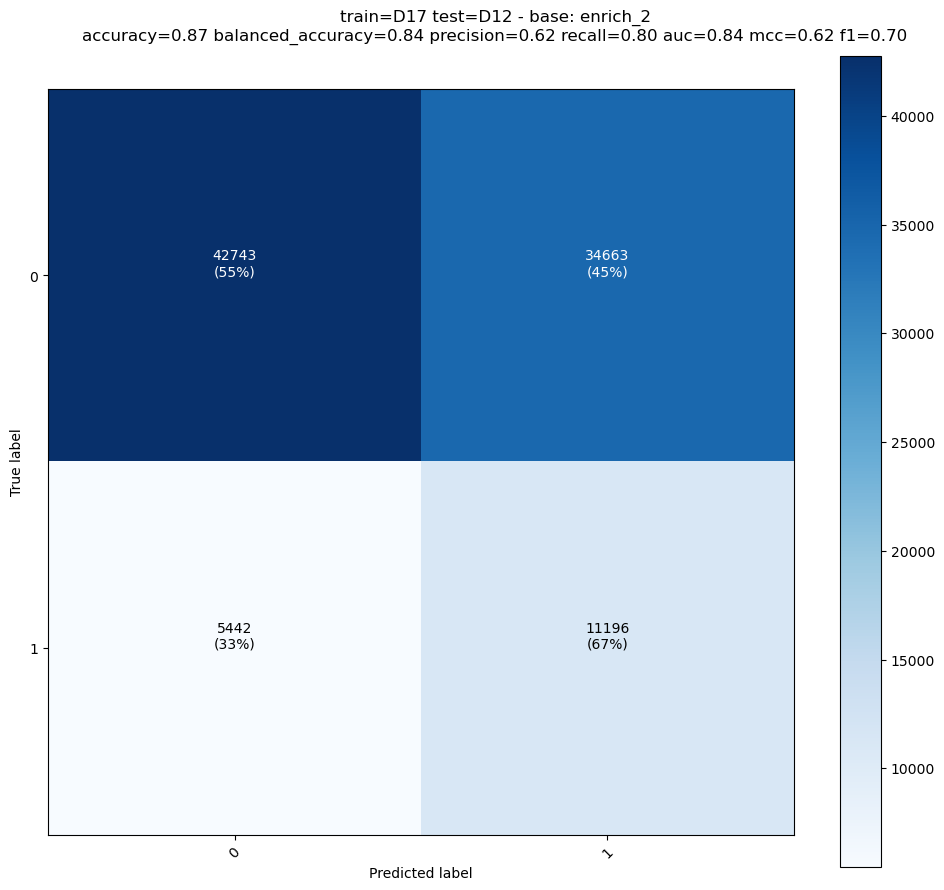

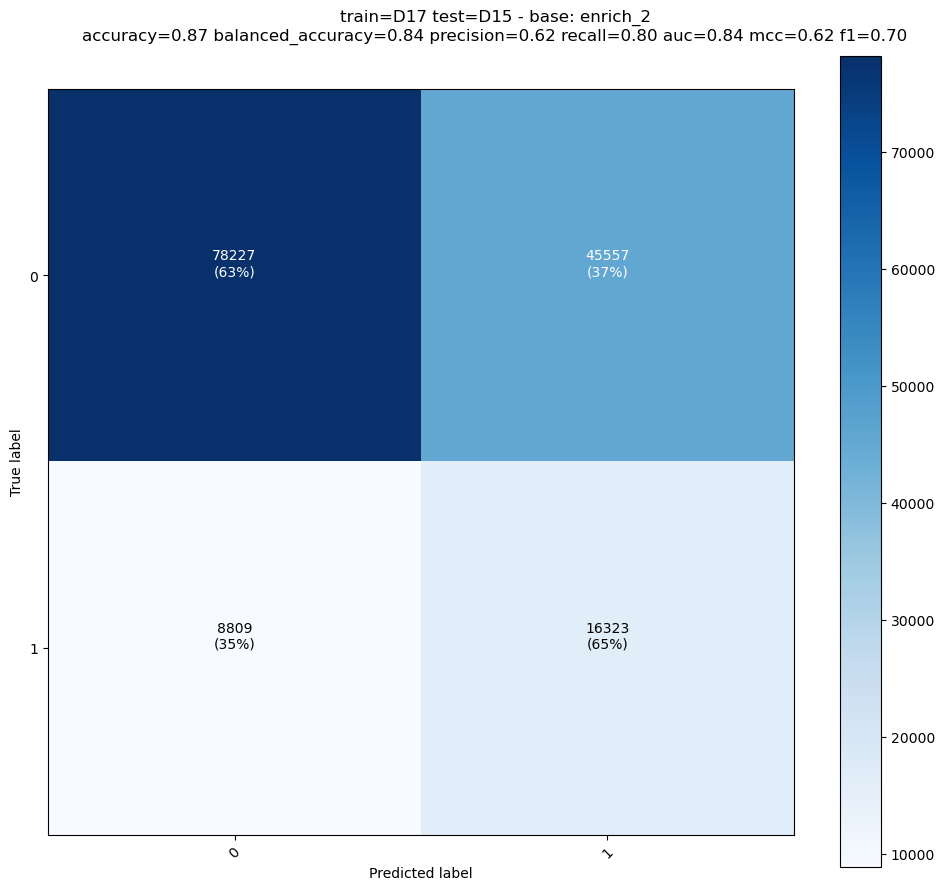

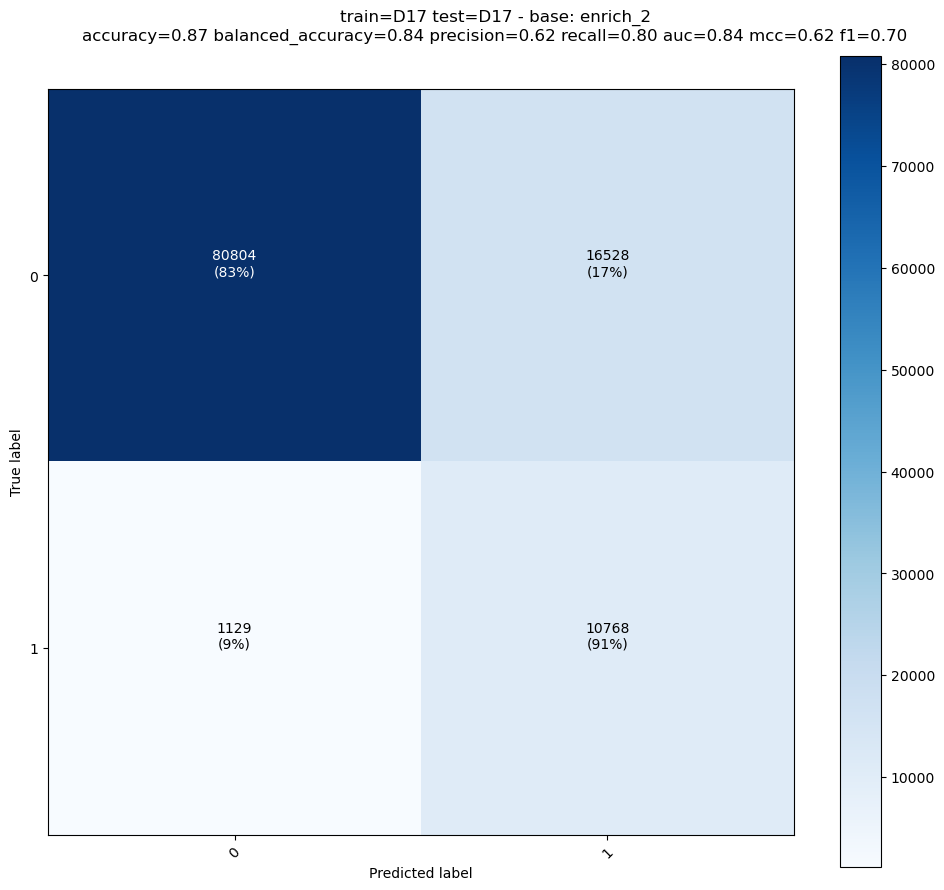

In [68]:
timepoints = ["D8", "D12", "D15", "D17"]
perf_per_time = {t: pd.DataFrame() for t in timepoints}
for condition_name in timepoints:
    estimator_t = models_t[condition_name]
    for to_pred_timepoint in timepoints:
        df_t = dataframe_days[dataframe_days["TimeCondition"] == to_pred_timepoint]
        x_t, y_t, groups_t = models.split_xy(
            df=df_t, x_columns=features_column, y_columns=target_column, groups=SAMPLE_GROUP
        )
        obs_t, pred_t = models.predict_model(x_t, y_t, estimator_t)
        # Metrics
        scores_t = models.scorer_model(
            estimator=estimator_t, x=x_t, y=y_t, scorer=SCORING_base
        )
        score_t_print = " ".join([f"{k}={v[0]:.2f}" for k,v in scores_t.items()])
        print(f"Train on {condition_name} pred on {to_pred_timepoint}/", score_t_print)
        display.display_confusion_matrix(
            observed=y_t, predicted=pred_t, cmap="Blues",
            labels=None, filepath=f"results/timepoint/train-test/{condition_name}_to_{to_pred_timepoint}_base-confusion_matrix.png",
            title=f"train={condition_name} test={to_pred_timepoint} - base: {target_column}\n{score_t_train_print}"
        )
        #
        perf_per_time[condition_name][to_pred_timepoint] = {k: v[0] for k,v in scores_t.items()}

In [ ]:
estimator = RandomForestClassifier(**estimator_param, random_state=SEED)
estimator.fit(x, y.ravel())
for cond_name, obs in dataframe_days.sort_values(by="TimeCondition").reset_index().groupby("TimeCondition"):
    idx = obs.index.to_numpy()
    display.display_confusion_matrix(
        observed=observed_days[idx], predicted=predicted_days[idx], cmap="Greens",
        labels=None, filepath=f"results/timepoint/time-{cond_name}_confusion_matrix.png", title=f"days ({cond_name}): {target_column}"
    )
    scores = models.scorer_model(
        estimator=estimator,
        x=x_days[idx], y=y_days[idx], scorer=SCORING_base
    )
    print("DAY=", cond_name, scores)